Methods
- Method overview
    - GLM
    - Moving average
    - BMA clusters
- Data/case study
    - SWA Data
- Model formulation
- Model parametrisation
    - The GLM is parameterised by water, emission, and normalised by area with yield as the predicted variable.
    - Clusters is done along multiple axes
- Performance measures
- Sensitivity analysis 
    
Results
- Compare variables and their distributions
- Compare regions and their distributions
    - Look at the bias in data towards certain regions
    - And, look at the bias in recording of certain variables
- Look at the GLM
    - What regions stand out within the model and what does it explain
- Look at the clusters
     - Can this be explained by regional differences
- Sensitivity analysis

### We have to clean up the data a little bit for this analysis.

We are going to remove a swath of rows that do not include enough information. This means we will deal with a subset of the data that were willing to report enough variables for the analysis to make sense. The baseline variables are fuel, water, area and yield.

In [17]:
# We import some libraries and read in the data
from carbon_converter import *
from data import *
from graph import multihist

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2
import rpy2.robjects as robjects
import rpy2.ipython.html

df = pd.read_feather('df.feather')
# TODO
# add nitrogen/fertiliser added together in data pipeline
df['nitrogen_applied'] = df['synthetic_nitrogen_applied']+df['organic_nitrogen_applied']
df['fertiliser_applied'] = df['synthetic_fertiliser_applied']+df['organic_fertiliser_applied']

# negative vineyard area harvested or likely typos
for id in df[df['area_harvested']<0.01].index:
    df = df.drop(index=id)
# remove radical outliers - caused mostly by incorrect units.
for id in df[df['water_used']>1000000].index:
    df = df.drop(index=id)

In [18]:
# There are some errors in spray data

df.loc[
    (df["insecticide_spraying_number_of_times_passes_per_year"]<1) & 
    (df["insecticide_spraying_number_of_times_passes_per_year"]!=0)
    , "insecticide_spraying_number_of_times_passes_per_year"] = 0


df.loc[
    (df["herbicide_spraying_number_of_times_passes_per_year"]<1) & 
    (df["herbicide_spraying_number_of_times_passes_per_year"]!=0)
    , "herbicide_spraying_number_of_times_passes_per_year"] = 0


In [19]:
# We convert the use of fuels into CO2E
# This includes both scope1 and scope 2 in the totals, as well as separate columns for comparison.
df["total_irrigation_electricity"] = df["total_irrigation_electricity"].apply(scope2)
df["irrigation_energy_diesel"] = df["irrigation_energy_diesel"].apply(diesel_irrigation)
df["irrigation_energy_electricity"] = df["irrigation_energy_electricity"].apply(scope2)
df["irrigation_energy_pressure"] = df["irrigation_energy_pressure"].apply(scope2)
df["diesel_vineyard"] = df["diesel_vineyard"].apply(diesel_vehicle)
df["electricity_vineyard"] = df["electricity_vineyard"].apply(scope2)
df["petrol_vineyard"] = df["petrol_vineyard"].apply(petrol_vehicle)
df["lpg_vineyard"] = df["lpg_vineyard"].apply(lpg_vehicle)
df["biodiesel_vineyard"] = df["biodiesel_vineyard"].apply(biodiesel_vehicle)

df["use_renewable"] = 0
df.loc[(df["irrigation_energy_solar"]>0) | (df["vineyard_wind"]>0) | (df["vineyard_solar"]),"use_renewable"] += 1

df["scope2"] = df["total_irrigation_electricity"]\
    + df["irrigation_energy_electricity"]\
    + df["irrigation_energy_pressure"]\
    + df["electricity_vineyard"]

df["scope1"] = df["irrigation_energy_diesel"]\
    + df["diesel_vineyard"]\
    + df["petrol_vineyard"]\
    + df["lpg_vineyard"]\
    + df["biodiesel_vineyard"]

df["total_emissions"] = df["scope1"] + df["scope2"]

In [20]:
# we limit it to recordings for the baseline variables.
df = df.replace({0: np.nan})
df = df[(df["area_harvested"].notnull()) & (df["tonnes_grapes_harvested"].notnull()) & (df["water_used"].notnull()) & (df["total_vineyard_fuel"].notnull())]

In [21]:
# We are going to transform the data so that it is distributed normally.
# This involves removing the top and bottom 1% as they contain several radicals
#
# These radicals may be mis recordings or freak events in the data. They are 
# disparate enough to remove.

log_df = df.copy()
log_df["area_harvested"] += 1

ids = []
for col in [
    "water_used"
    , "tonnes_grapes_harvested"
    , "total_vineyard_fuel"
    , "total_vineyard_electricity"
]:
    log_df[col] = log_df[col].apply(np.log).div(log_df["area_harvested"].apply(np.log))

    #log_df = log_df.loc[
    #    log_df[col].sort_values().iloc[round(len(log_df)*.005):round(len(log_df)-len(df)*.005)].index
    #]

for col in [
    "total_emissions"
    , "scope1"
    , "scope2"
]:
    log_df[col] += 1
    log_df[col] = log_df[col].apply(np.log).div(log_df["area_harvested"].apply(np.log))

### We have a look at the sparsity of particular variables

In [22]:
feature_list = [
    "area_harvested"
    , "tonnes_grapes_harvested"
    , "water_used"
    , "total_tractor_passes"
    , "synthetic_nitrogen_applied"
    , "organic_nitrogen_applied"
    , "synthetic_fertiliser_applied"
    , "organic_fertiliser_applied"
    , "slashing_number_of_times_passes_per_year"
    , "fungicide_spraying_number_of_times_passes_per_year"
    , "herbicide_spraying_number_of_times_passes_per_year"
    , "insecticide_spraying_number_of_times_passes_per_year"
    , "nitrogen_applied"
    , "fertiliser_applied"
    , "total_emissions"
]

total = len(log_df)
print("n = {}".format(total))
print("Proportion of entries in each column:\n")
for feature in feature_list:
    entries = len(log_df[log_df[feature].notnull()][feature])
    print("{}: {} | {}%".format(feature, entries, round((entries/total)*100, 2)))

n = 5403
Proportion of entries in each column:

area_harvested: 5403 | 100.0%
tonnes_grapes_harvested: 5403 | 100.0%
water_used: 5403 | 100.0%
total_tractor_passes: 1978 | 36.61%
synthetic_nitrogen_applied: 140 | 2.59%
organic_nitrogen_applied: 138 | 2.55%
synthetic_fertiliser_applied: 428 | 7.92%
organic_fertiliser_applied: 303 | 5.61%
slashing_number_of_times_passes_per_year: 1939 | 35.89%
fungicide_spraying_number_of_times_passes_per_year: 1923 | 35.59%
herbicide_spraying_number_of_times_passes_per_year: 1736 | 32.13%
insecticide_spraying_number_of_times_passes_per_year: 934 | 17.29%
nitrogen_applied: 253 | 4.68%
fertiliser_applied: 616 | 11.4%
total_emissions: 5403 | 100.0%


### We look at the proportion of entries for each region:

In [23]:
total = len(log_df)
print("n = {}".format(total))
print("number of regions is {}".format(len(log_df["giregion"].unique())))
print("Proportion of entries in each column:\n")
for region in log_df["giregion"].unique():
    entries = len(log_df[log_df["giregion"]==region]["giregion"])
    print("{}: {} | {}%".format(region, entries, round((entries/total)*100, 2)))

n = 5403
number of regions is 58
Proportion of entries in each column:

Barossa Valley: 515 | 9.53%
Padthaway: 179 | 3.31%
Hunter Valley: 55 | 1.02%
Coonawarra: 267 | 4.94%
Rutherglen: 29 | 0.54%
Langhorne Creek: 319 | 5.9%
Clare Valley: 126 | 2.33%
Riverland: 445 | 8.24%
Murray Darling: 496 | 9.18%
Upper Goulburn: 20 | 0.37%
Swan Hill: 82 | 1.52%
Adelaide Hills: 410 | 7.59%
Bendigo: 52 | 0.96%
Grampians: 70 | 1.3%
Henty: 20 | 0.37%
Mount Benson: 17 | 0.31%
Wrattonbully: 160 | 2.96%
Robe: 36 | 0.67%
Currency Creek: 20 | 0.37%
Southern Fleurieu: 29 | 0.54%
McLaren Vale: 1025 | 18.97%
Yarra Valley: 108 | 2.0%
Margaret River: 301 | 5.57%
Blackwood Valley: 8 | 0.15%
Glenrowan: 4 | 0.07%
Riverina: 16 | 0.3%
Eden Valley: 89 | 1.65%
Other: 18 | 0.33%
Big Rivers Zone Other: 9 | 0.17%
Heathcote: 28 | 0.52%
Orange: 49 | 0.91%
Kangaroo Island: 10 | 0.19%
0: 22 | 0.41%
Cowra: 6 | 0.11%
Mornington Peninsula: 28 | 0.52%
Adelaide Plains: 25 | 0.46%
Mount Gambier: 9 | 0.17%
Southern Flinders Ranges: 1

In [24]:
log_df.groupby("giregion")["member_id"].count().describe()

count      58.000000
mean       93.155172
std       178.756602
min         1.000000
25%         9.000000
50%        21.000000
75%        79.000000
max      1025.000000
Name: member_id, dtype: float64

In [25]:
region_selection = df.groupby("giregion").count()[(df.groupby("giregion").count()>50)["member_id"]].index.values
region_selection = list(region_selection).append("other")

### How do the variables correlate to each other

In [26]:
log_df[feature_list].corr().style.background_gradient(cmap='coolwarm')

### How are the varaible distributed

In [27]:
df = df.loc[log_df.index]
log_df = None

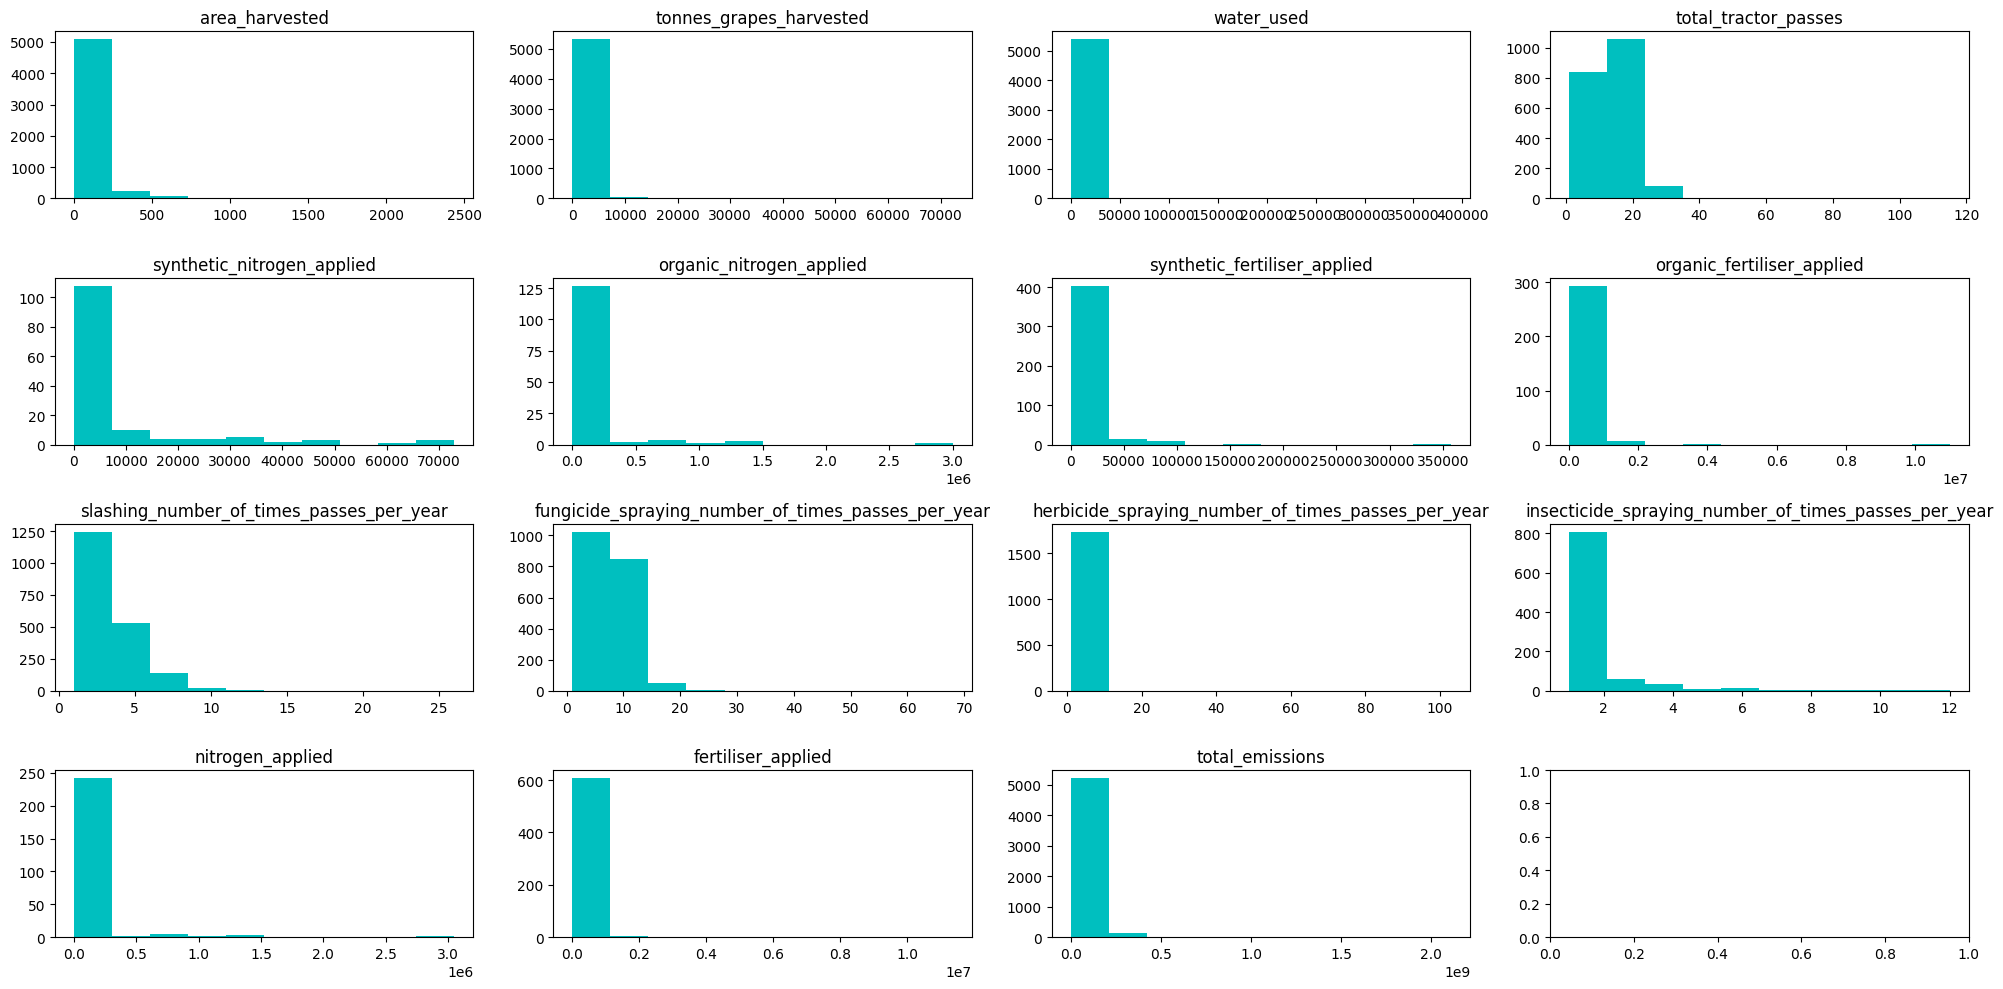

In [28]:
multihist(df[feature_list])
plt.tight_layout()

There are notably two problems with this data. It is skewed due to there being more smalelr wineries than larger, and that there are a few outliers that are likely due to user error. We remove the top and bottom ends and this fixes it.

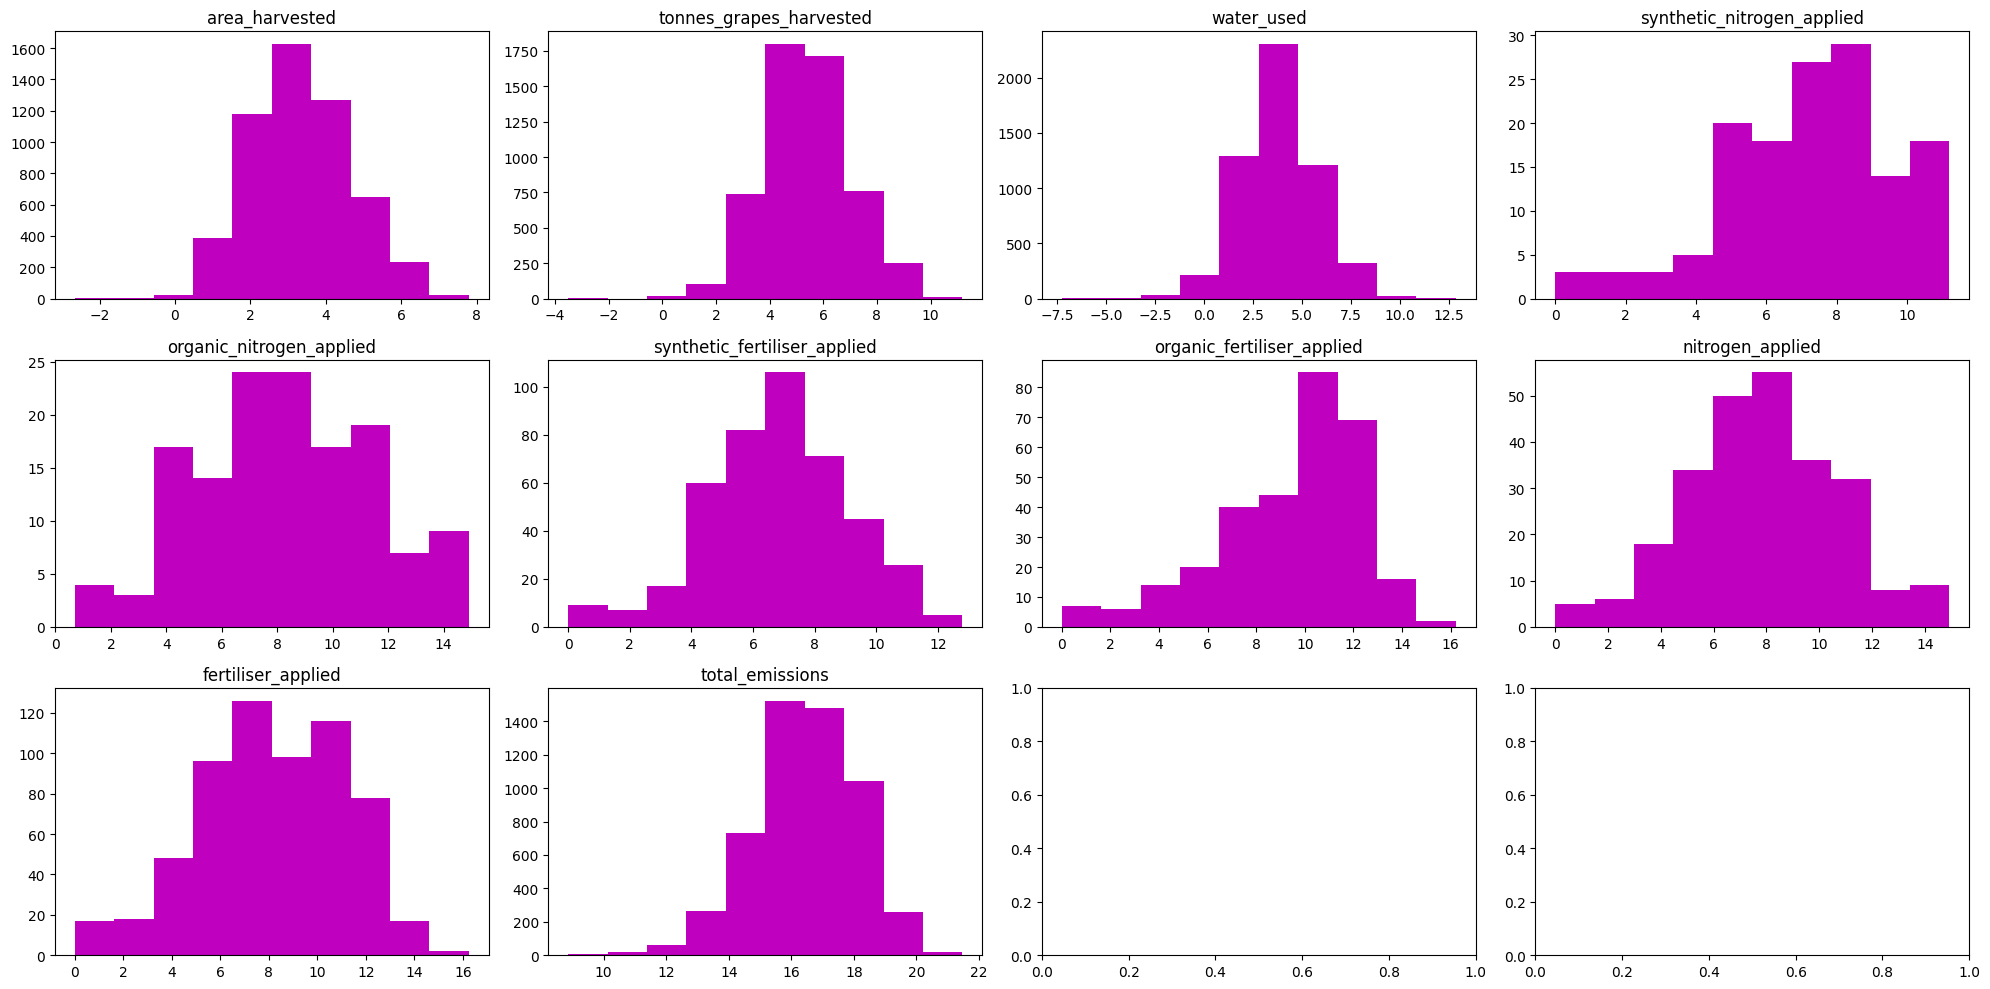

In [29]:
#If values graphed below are overwhelming large then a random error has occurred. Rerun the cell until the dissapear.
fig, ax = multihist(df[[
    "area_harvested"
    , "tonnes_grapes_harvested"
    , "water_used"
    , "synthetic_nitrogen_applied"
    , "organic_nitrogen_applied"
    , "synthetic_fertiliser_applied"
    , "organic_fertiliser_applied"
    , "nitrogen_applied"
    , "fertiliser_applied"
    , "total_emissions"
]].apply(np.log), color="m")
plt.tight_layout()

In [30]:
df['tonnes_grapes_harvested'].div(df["area_harvested"]).describe()

count    5403.000000
mean       10.330859
std         8.230886
min         0.040000
25%         5.140845
50%         7.471429
75%        12.164701
max        86.336364
dtype: float64

In [31]:
len(feature_list)

15

### GLM Baseline

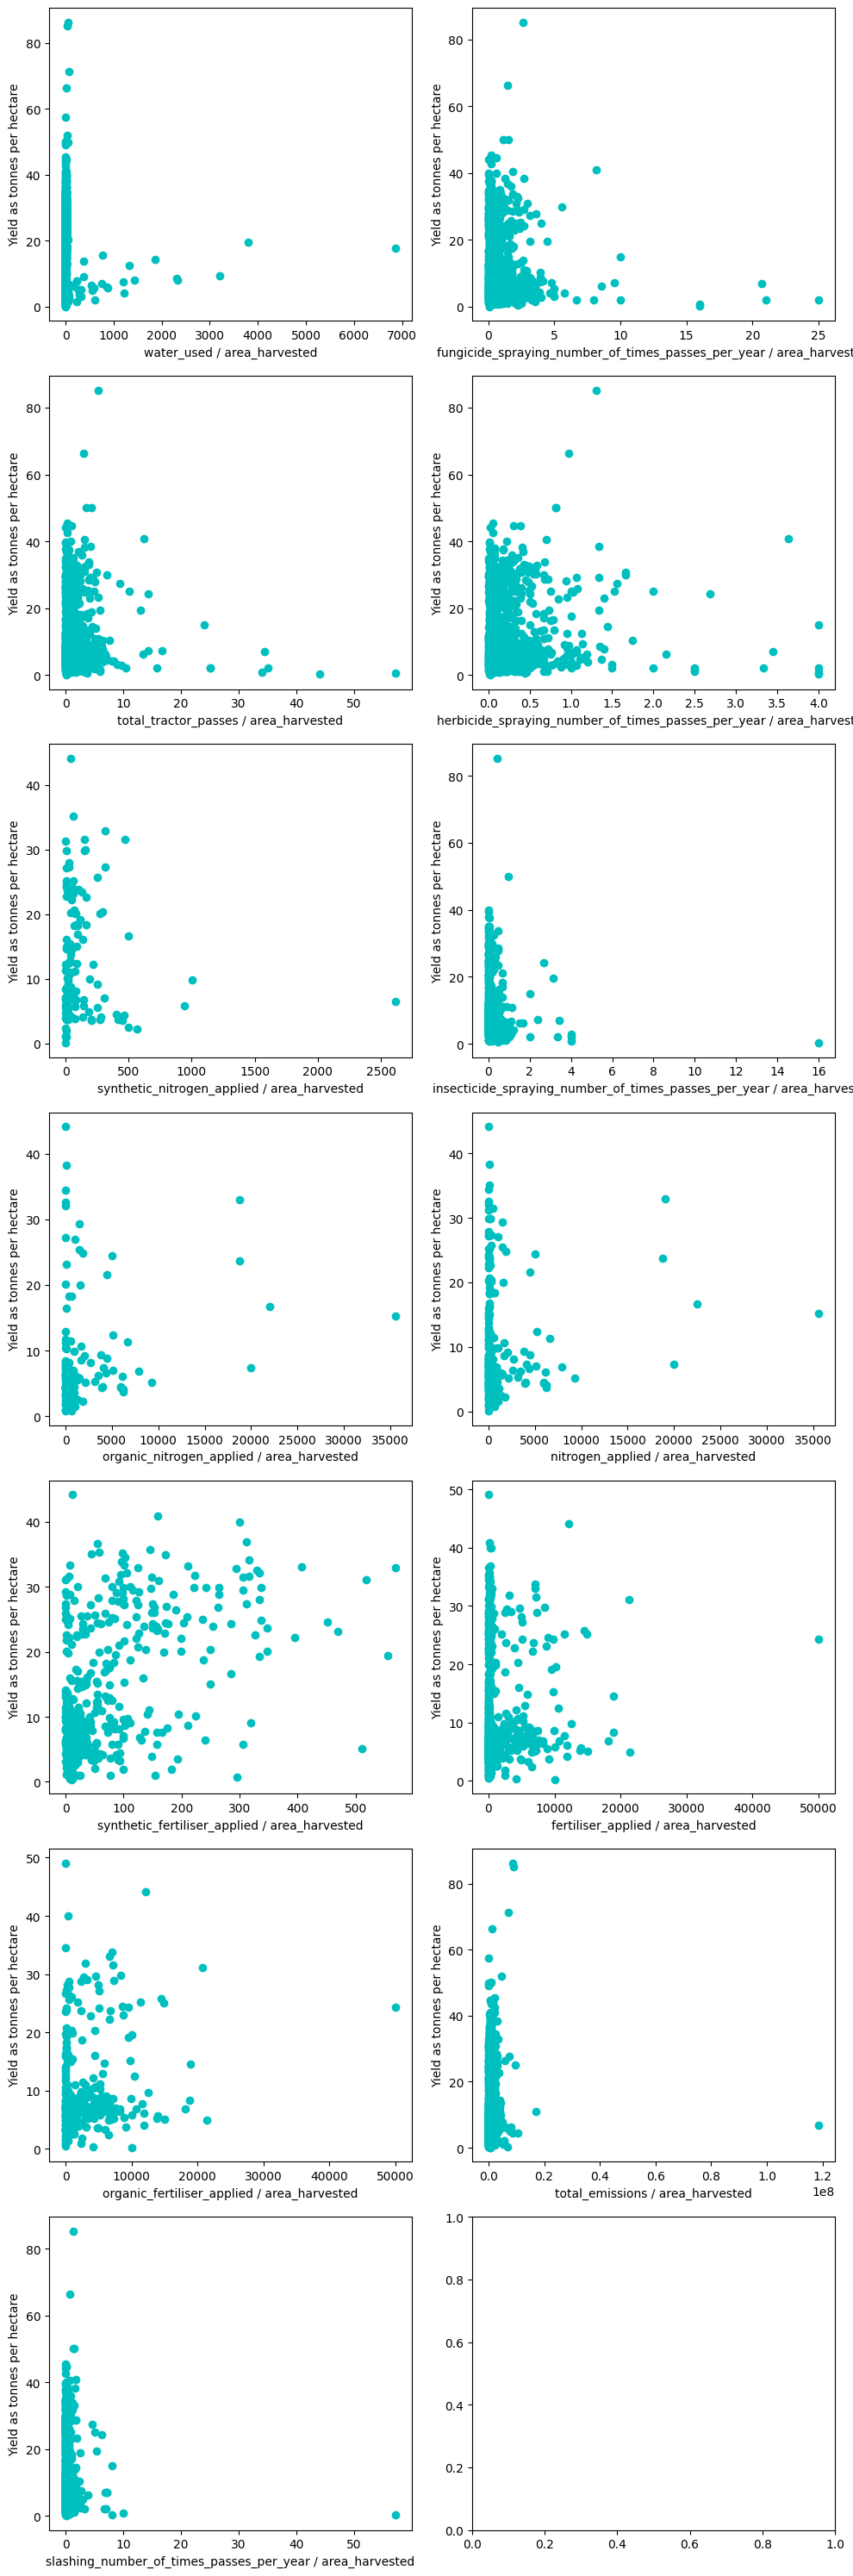

In [32]:
rows = int(round((len(feature_list))/2))-1
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10, 30))

i = 0
j = 0
for feature in feature_list:
    if feature == 'tonnes_grapes_harvested':
        continue
    if feature == 'area_harvested':
        continue
    ax[i][j].scatter(df[feature].div(df["area_harvested"]),
                  df['tonnes_grapes_harvested'].div(df["area_harvested"]), color="c")
    ax[i][j].set_xlabel("{} / area_harvested".format(feature))
    ax[i][j].set_ylabel("Yield as tonnes per hectare")
    i += 1
    if i == rows:
        j+=1
        i=0

#fig.text(-0.01, 0.5, "Yield as tonnes per hectare", va="center", rotation='vertical')
fig.tight_layout()
plt.show()

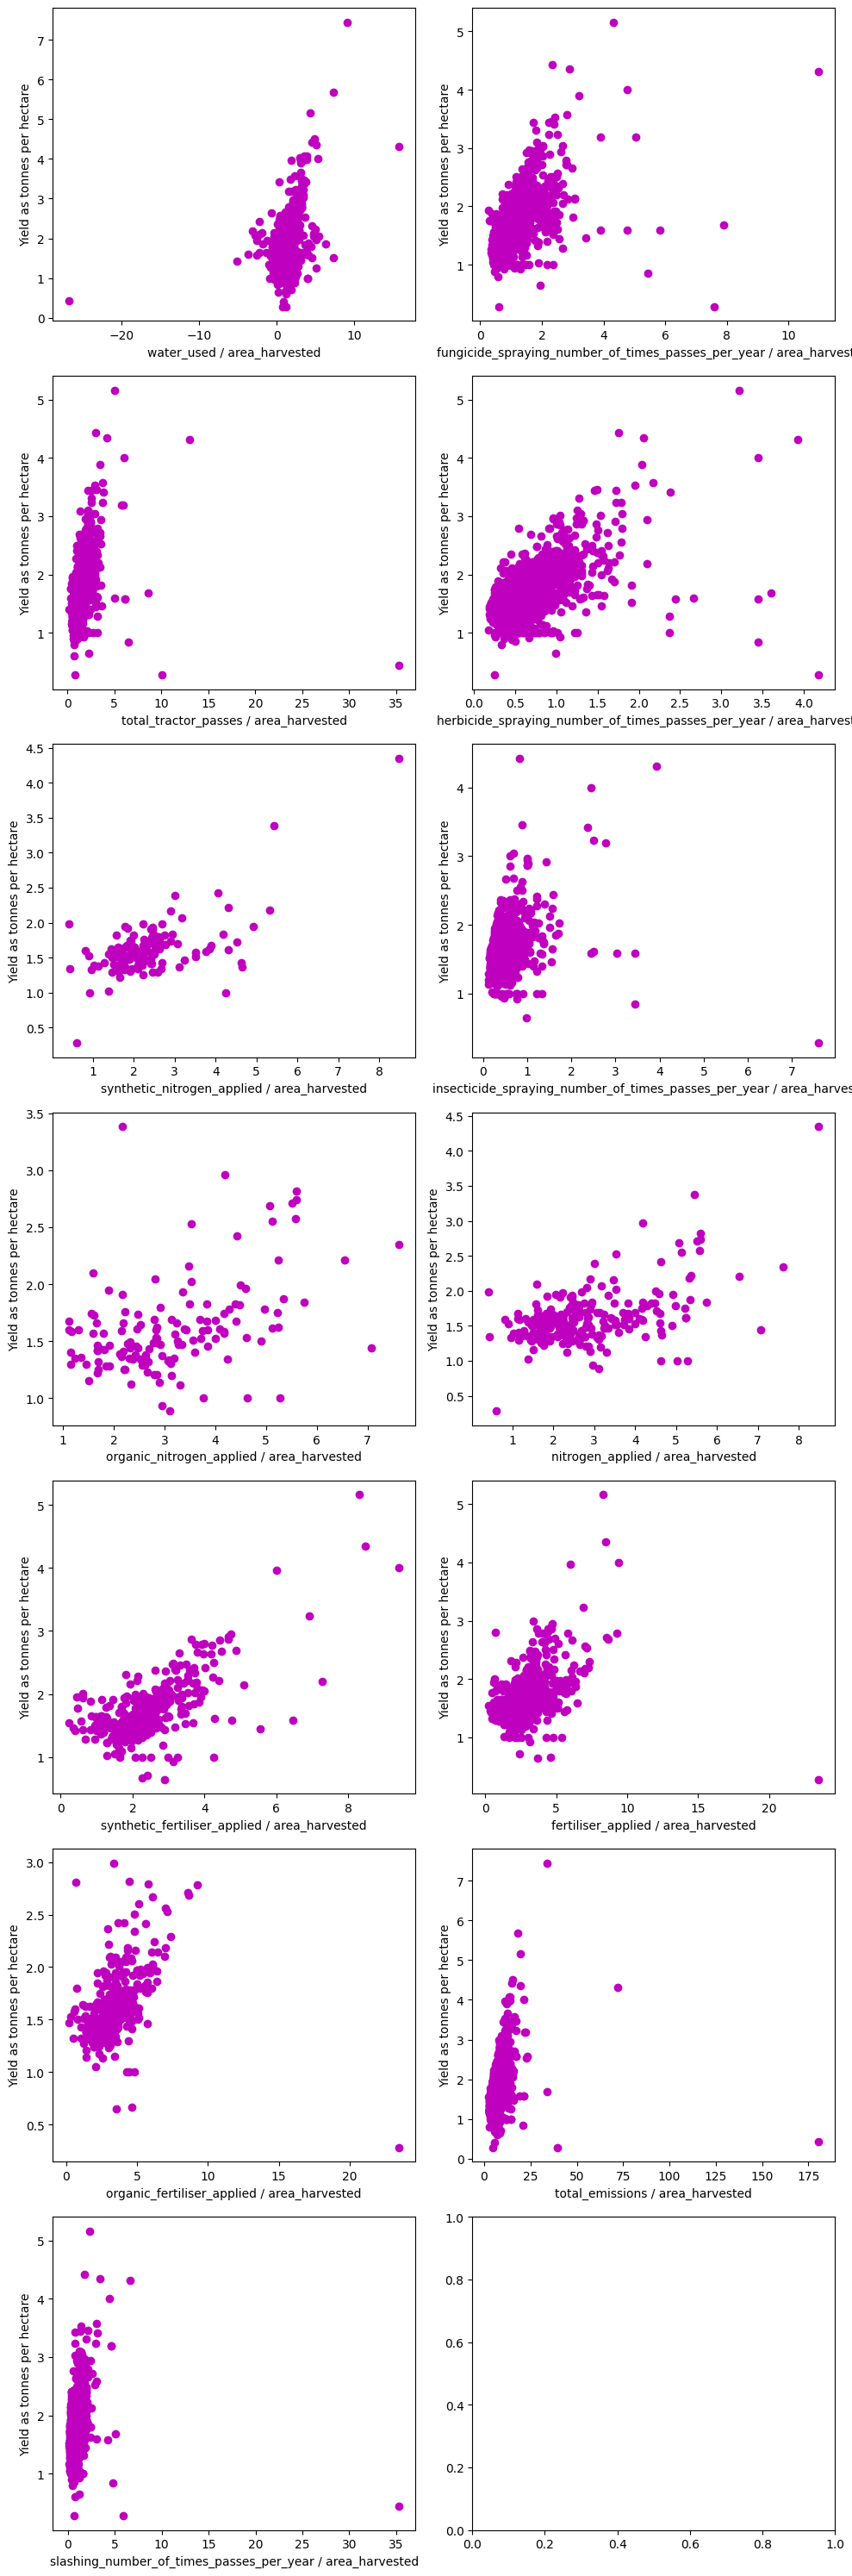

In [33]:
rows = int(round((len(feature_list))/2))-1
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10, 30))

i = 0
j=0
for feature in feature_list:
    if feature == 'tonnes_grapes_harvested':
        continue
    if feature == 'area_harvested':
        continue 
    ax[i][j].scatter((1+df[feature].apply(np.log)).div((1+df["area_harvested"]).apply(np.log))
                  , (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))
                  , color="m")
    ax[i][j].set_xlabel("{} / area_harvested".format(feature))
    ax[i][j].set_ylabel("Yield as tonnes per hectare")
    i += 1
    if i == rows:
        j+=1
        i=0
        
#fig.text(0.04, 0.5, "Yield", ha="center", rotation='vertical')
fig.tight_layout()
plt.show()

In [34]:
df[feature_list].replace({np.nan: 0})["nitrogen_applied"].describe()

count    5.403000e+03
mean     3.060693e+03
std      5.891995e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.050000e+06
Name: nitrogen_applied, dtype: float64

In [35]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "(df$tonnes_grapes_harvested)/(df$area_harvested)"
    "~ (df$total_emissions)/(df$area_harvested)"
    "+ (df$water_used)/(df$area_harvested) "
    "+ (df$total_tractor_passes)"
    "+ (df$synthetic_nitrogen_applied)/(df$area_harvested)"
    "+ (df$organic_nitrogen_applied)/(df$area_harvested)"
    "+ (df$synthetic_fertiliser_applied)/(df$area_harvested)"
    "+ (df$organic_fertiliser_applied)/(df$area_harvested)"
    "+ (df$slashing_number_of_times_passes_per_year)"
    "+ (df$fungicide_spraying_number_of_times_passes_per_year)"
    "+ (df$herbicide_spraying_number_of_times_passes_per_year)"
    "+ (df$insecticide_spraying_number_of_times_passes_per_year)"
    "+ (df$nitrogen_applied)/(df$area_harvested)"
    "+ (df$fertiliser_applied)/(df$area_harvested)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (df$tonnes_grapes_harvested)/(df$area_harvested)

Terms added sequentially (first to last)


                                                        Df Deviance Resid. Df
NULL                                                                     5402
df$total_emissions                                       1   3487.3      5401
df$water_used                                            1    131.7      5400
df$total_tractor_passes                                  1    192.1      5399
df$synthetic_nitrogen_applied                            1    893.0      5398
df$organic_nitrogen_applied                              1    300.0      5397
df$synthetic_fertiliser_applied                          1   3300.5      5396
df$organic_fertiliser_applied                            1    169.4      5395
df$slashing_number_of_times_passes_per_year              1    584.6      5394
df$fungicide_spraying_

df$total_emissions:df$area_harvested                     -4.581 0.000004738435
df$area_harvested:df$water_used                           1.355         0.1754
df$area_harvested:df$synthetic_nitrogen_applied          -0.160         0.8730
df$area_harvested:df$organic_nitrogen_applied             1.286         0.1983
df$area_harvested:df$synthetic_fertiliser_applied        -5.985 0.000000002309
df$area_harvested:df$organic_fertiliser_applied           2.090         0.0367
                                                           
(Intercept)                                             ***
df$total_emissions                                      ***
df$water_used                                              
df$total_tractor_passes                                    
df$synthetic_nitrogen_applied                              
df$organic_nitrogen_applied                                
df$synthetic_fertiliser_applied                         ***
df$organic_fertiliser_applied                 

<rpy2.robjects.vectors.ListVector object at 0x7f16bcdf3700> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f16bcc7ef40> [RTYPES.REALSXP]
R classes: ('numeric',)
[9.612350, 0.000000, -0.000008, -3.941265, ..., -0.000000, 0.000000,      nan,      nan]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f167bd915c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[-4.294068, -5.835795, -5.401075, -3.396709, ..., -3.355745, 20.492280, 3.546793, -5.056725]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f1682c59900> [RTYPES.REALSXP]
R classes: ('numeric',)
[10.342261, 10.568190, 10.532943, 10.586029, ..., 9.868245, 14.400924, 19.587535, 10.441340]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f167bd420c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[-759.370821, -59.053135, 11.475907, 13.858694, ..., -3.518421, 20.536455, 3.799277, -5.197522]
...
<rpy2.robjects.vectors.ListVector object at 0x7f16bcdf3700> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f167bdb7fc0> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f16c0a847c0> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7f16bcdf3700> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [36]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1)"
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
    "+ (df$total_tractor_passes)"
    "+ log(df$synthetic_nitrogen_applied+1)/log(df$area_harvested+1)"
    "+ log(df$organic_nitrogen_applied+1)/log(df$area_harvested+1)"
    "+ log(df$synthetic_fertiliser_applied+1)/log(df$area_harvested+1)"
    "+ log(df$organic_fertiliser_applied+1)/log(df$area_harvested+1)"
    "+ (df$slashing_number_of_times_passes_per_year)"
    "+ (df$fungicide_spraying_number_of_times_passes_per_year)"
    "+ (df$herbicide_spraying_number_of_times_passes_per_year)"
    "+ (df$insecticide_spraying_number_of_times_passes_per_year)"
    "+ log(df$nitrogen_applied+1)/log(df$area_harvested+1)"
    "+ log(df$fertiliser_applied+1)/log(df$area_harvested+1)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                                    Df Deviance
NULL                                                                           
log(df$total_emissions + 1)                                          1  141.048
log(df$water_used + 1)                                               1    5.687
df$total_tractor_passes                                              1    0.706
log(df$synthetic_nitrogen_applied + 1)                               1    0.087
log(df$organic_nitrogen_applied + 1)                                 1    0.517
log(df$synthetic_fertiliser_applied + 1)                             1    3.907
log(df$organic_fertiliser_applied + 1)                               1    0.248
df$slashing_number_of_times_passes_per_year                         

log(df$organic_fertiliser_applied + 1)                               0.0146660
df$slashing_number_of_times_passes_per_year                          0.1323862
df$fungicide_spraying_number_of_times_passes_per_year                0.1322840
df$herbicide_spraying_number_of_times_passes_per_year                0.1321744
df$insecticide_spraying_number_of_times_passes_per_year              0.1320100
log(df$nitrogen_applied + 1)                                         0.0339335
log(df$fertiliser_applied + 1)                                       0.0174438
log(df$total_emissions + 1):log(df$area_harvested + 1)               0.0006950
log(df$area_harvested + 1):log(df$water_used + 1)                    0.0019251
log(df$area_harvested + 1):log(df$synthetic_nitrogen_applied + 1)    0.0072078
log(df$area_harvested + 1):log(df$organic_nitrogen_applied + 1)      0.0071433
log(df$area_harvested + 1):log(df$synthetic_fertiliser_applied + 1)  0.0038268
log(df$area_harvested + 1):log(df$organic_fertiliser

                                                      -0.0253194256 
                  log(df$area_harvested + 1):log(df$water_used + 1) 
                                                       0.0300652004 
  log(df$area_harvested + 1):log(df$synthetic_nitrogen_applied + 1) 
                                                       0.0048910771 
    log(df$area_harvested + 1):log(df$organic_nitrogen_applied + 1) 
                                                       0.0021323912 
log(df$area_harvested + 1):log(df$synthetic_fertiliser_applied + 1) 
                                                      -0.0001733731 
  log(df$area_harvested + 1):log(df$organic_fertiliser_applied + 1) 
                                                       0.0104605972 
            log(df$area_harvested + 1):log(df$nitrogen_applied + 1) 
                                                      -0.0002449429 
          log(df$area_harvested + 1):log(df$fertiliser_applied + 1) 
                                  

<rpy2.robjects.vectors.ListVector object at 0x7f167bfe6c40> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f1682ba44c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.101204, 0.094901, 0.003249, -0.080522, ..., -0.000173, 0.010461, -0.000245, -0.009289]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f1682793540> [RTYPES.REALSXP]
R classes: ('numeric',)
[-0.047710, -0.109323, -0.054707, -0.047997, ..., 0.146634, 0.060821, 0.071051, -0.084106]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f16829cf3c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.451648, 1.470216, 1.414450, 1.476304, ..., 2.002190, 1.831323, 1.688364, 1.929655]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f17185b03c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[-122.380532, 11.876359, 2.384732, 0.840520, ..., 0.143350, 0.063008, 0.089221, -0.083546]
...
<rpy2.robjects.vectors.ListVector object at 0x7f167bfe6c40> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f167bfdfd40> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f16c0a847c0> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7f167bfe6c40> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [37]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1)"
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1)"
    "+ log(df$fertiliser_applied + 1)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    5402
log(df$total_emissions + 1)                             1  141.048      5401
log(df$water_used + 1)                                  1    5.687      5400
log(df$fertiliser_applied + 1)                          1    1.172      5399
log(df$total_emissions + 1):log(df$area_harvested + 1)  1  149.768      5398
log(df$area_harvested + 1):log(df$water_used + 1)       1   19.683      5397
                                                       Resid. Dev
NULL                                                       765.95
log(df$total_emissions + 1)                                624.91
log(df$water_used + 1)                             

<rpy2.robjects.vectors.ListVector object at 0x7f1718470b40> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f1682b110c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.099820, 0.094136, 0.008710, 0.003448, -0.025293, 0.029294]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f167bd6a380> [RTYPES.REALSXP]
R classes: ('numeric',)
[-0.044660, -0.106190, -0.051143, -0.001642, ..., 0.149236, 0.136546, 0.135428, -0.067413]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f167bd6a200> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.448598, 1.467083, 1.410885, 1.429949, ..., 1.999587, 1.755599, 1.623988, 1.912962]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f167bd28f40> [RTYPES.REALSXP]
R classes: ('numeric',)
[-122.380532, 11.876359, 2.384732, -1.082487, ..., 0.147213, 0.139316, 0.136707, -0.064875]
...
<rpy2.robjects.vectors.ListVector object at 0x7f1718470b40> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f167be2df40> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f16c0a847c0> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7f1718470b40> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [38]:
rpy2.ipython.html.init_printing()
r = robjects.r

df.to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    5402
log(df$total_emissions + 1)                             1  141.048      5401
log(df$water_used + 1)                                  1    5.687      5400
log(df$total_emissions + 1):log(df$area_harvested + 1)  1  150.293      5399
log(df$area_harvested + 1):log(df$water_used + 1)       1   19.835      5398
                                                       Resid. Dev
NULL                                                       765.95
log(df$total_emissions + 1)                                624.91
log(df$water_used + 1)                                     619.22
log(df$total_emissions + 1):log(df$area_harvested + 1)     468

In [39]:
model[4]

<rpy2.robjects.vectors.FloatMatrix object at 0x7f1682be4480> [RTYPES.REALSXP]
R classes: ('matrix', 'array')
[-73.505102, 0.000000, 0.000000, 0.000000, ..., -638.978570, 463.623795, -222.707487, 151.486839]

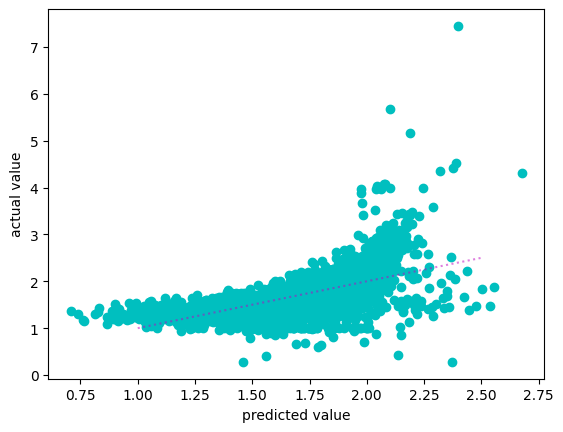

In [40]:
fig, ax = plt.subplots()

plt.plot([1,2.5], [1,2.5], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c")

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

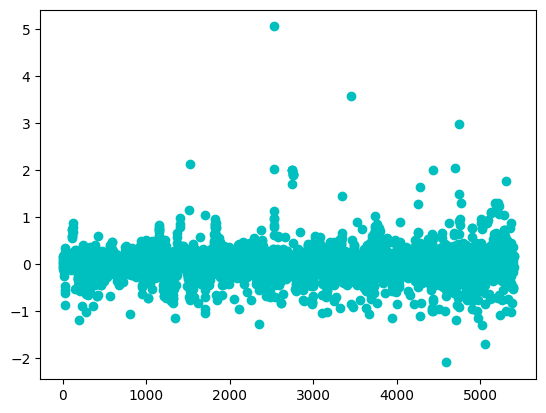

In [41]:
residuals = model[1]
plt.scatter(range(len(residuals)), residuals, color="c")

In [42]:
np.std(np.array(residuals))

0.28830355484306336

In [43]:
np.max(np.array(residuals))

5.049880851208944

In [44]:
np.min(np.array(residuals))

-2.093828756366962

(array([1.000e+00, 1.000e+00, 1.500e+01, 8.300e+01, 3.170e+02, 2.902e+03,
        1.836e+03, 1.780e+02, 4.200e+01, 1.000e+01, 4.000e+00, 1.100e+01,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-2.09382876, -1.73664328, -1.3794578 , -1.02227232, -0.66508683,
        -0.30790135,  0.04928413,  0.40646961,  0.76365509,  1.12084057,
         1.47802605,  1.83521153,  2.19239701,  2.54958249,  2.90676797,
         3.26395345,  3.62113893,  3.97832441,  4.33550989,  4.69269537,
         5.04988085]),
 <BarContainer object of 20 artists>)

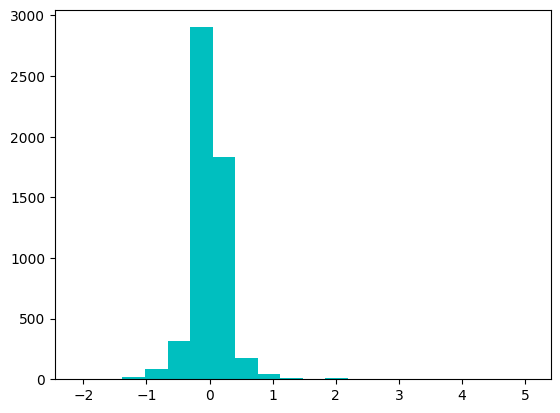

In [45]:
plt.hist(residuals, bins=20, color="c")

In [46]:
from scipy.stats import shapiro

shapiro(residuals)

/home/bryce/repositories/paper_one/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.831611156463623, pvalue=0.0)

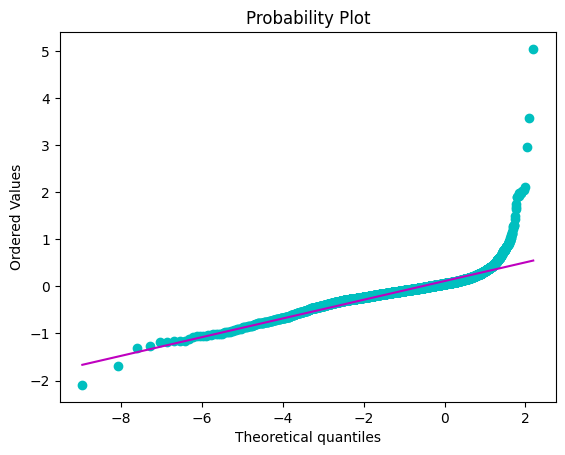

In [47]:
from scipy import stats



fig, ax = plt.subplots()

stats.probplot(
    residuals
    , dist=stats.loggamma
    , sparams=(1)
    , plot=ax
)
ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

### ???

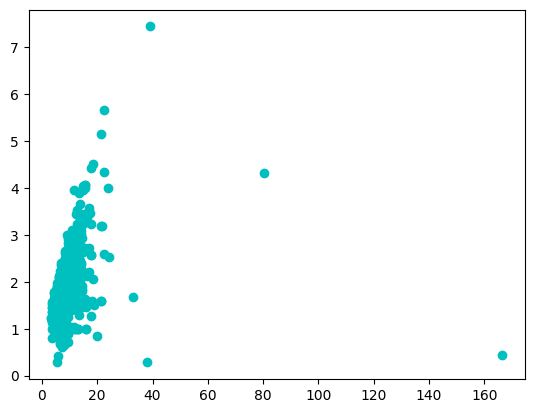

In [48]:
df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) +\
            ((1+df["total_emissions"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)))
df["yield"] = (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))

plt.scatter(df["water_and_emmissions"], df["yield"], color="c")


plt.show()

In [53]:
df["labels"] = labels
df.groupby("labels").describe()

field  member_id                                                             \
           count         mean          std     min      25%     50%     75%   
labels                                                                        
0         5112.0   642.176643   477.752741     1.0   273.00   551.5   900.0   
1          233.0   460.866953   508.584178     3.0   134.00   168.0   716.0   
2           25.0   290.760000   262.952987    22.0   134.00   137.0   393.0   
3            7.0   166.571429    87.563039   132.0   132.00   132.0   136.5   
4            8.0   415.125000   342.732481   132.0   133.50   365.0   453.0   
5            6.0   205.666667   158.400337   141.0   141.00   141.0   141.0   
6            4.0   219.750000   163.555037   132.0   138.75   141.0   222.0   
7            2.0  1300.000000  1180.868325   465.0   882.50  1300.0  1717.5   
8            1.0  1315.000000          NaN  1315.0  1315.00  1315.0  1315.0   
9            1.0  1315.000000          NaN  1315.0  1315.00  1315.0  1315.0   
10           1.0   141.000000          NaN   141.0   141.00   141.0   141.0   
11           1.0   141.000000          NaN   141.0   141.00   141.0   141.0   
12           1.0   465.000000          NaN   465.0   465.00   465.0   465.0   
13           1.0   529.000000          NaN   529.0   529.00   529.0   529.0   

field          vineyard_area               ... water_and_emmissions  \
           max         count         mean  ...                  75%   
labels                                     ...                        
0       2187.0        5112.0    49.395319  ...             7.487901   
1       2076.0         233.0   377.120258  ...             4.737479   
2        717.0          25.0   444.465600  ...             4.590768   
3        365.0           7.0   942.760000  ...             4.052119   
4       1111.0           8.0   456.533750  ...             4.470200   
5        529.0           6.0  1553.333333  ...             3.919829   
6        465.0           4.0  1424.810000  ...             3.964569   
7       2135.0           2.0  1405.000000  ...             4.002744   
8       1315.0           1.0  2436.150000  ...             4.020262   
9       1315.0           1.0  2436.150000  ...             3.941277   
10       141.0           1.0  1685.000000  ...             3.820512   
11       141.0           1.0  1589.000000  ...             3.783668   
12       465.0           1.0  1376.000000  ...             4.042770   
13       529.0           1.0  1290.000000  ...             4.200269   

field                yield                                                    \
               max   count      mean       std       min       25%       50%   
labels                                                                         
0       166.410496  5112.0  1.679636  0.380556  0.279415  1.458163  1.610136   
1         5.911947   233.0  1.421201  0.123937  1.139081  1.332653  1.423827   
2         5.017199    25.0  1.437906  0.128904  1.203811  1.334855  1.429198   
3         4.188374     7.0  1.217286  0.091133  1.050945  1.198333  1.221287   
4         5.998811     8.0  1.365842  0.201773  1.170743  1.243398  1.320021   
5         4.220142     6.0  1.295317  0.123506  1.202415  1.226384  1.260992   
6         4.310106     4.0  1.161918  0.049169  1.109926  1.131525  1.156946   
7         4.002744     2.0  1.214557  0.000000  1.214557  1.214557  1.214557   
8         4.020262     1.0  1.434704       NaN  1.434704  1.434704  1.434704   
9         3.941277     1.0  1.340112       NaN  1.340112  1.340112  1.340112   
10        3.820512     1.0  1.162542       NaN  1.162542  1.162542  1.162542   
11        3.783668     1.0  1.227136       NaN  1.227136  1.227136  1.227136   
12        4.042770     1.0  1.273416       NaN  1.273416  1.273416  1.273416   
13        4.200269     1.0  1.473989       NaN  1.473989  1.473989  1.473989   

field                       
             75%       max  
labels                      


In [54]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df[feature_list].replace({np.nan: 0}))
for i in range(len(pca.explained_variance_ratio_)):
    print("{}: {}".format(feature_list[i], pca.explained_variance_ratio_[i]))
    print("{}: {}".format(feature_list[i], pca.singular_values_[i]))

area_harvested: 0.9999917921948664
area_harvested: 6362323042.839877
tonnes_grapes_harvested: 7.27178591717571e-06
tonnes_grapes_harvested: 17156869.227142338
water_used: 9.134259933145831e-07
water_used: 6080708.461416627
total_tractor_passes: 1.1603893286325224e-08
total_tractor_passes: 685360.9592928544
synthetic_nitrogen_applied: 9.452420094353596e-09
synthetic_nitrogen_applied: 618570.2174831631
organic_nitrogen_applied: 1.2686652175884802e-09
organic_nitrogen_applied: 226616.23257068693
synthetic_fertiliser_applied: 2.678120573197158e-10
synthetic_fertiliser_applied: 104119.61691029632
organic_fertiliser_applied: 4.2160656665788685e-13
organic_fertiliser_applied: 4131.152070355145
slashing_number_of_times_passes_per_year: 1.018958245099357e-14
slashing_number_of_times_passes_per_year: 642.2375478004828
fungicide_spraying_number_of_times_passes_per_year: 4.053257015435405e-16
fungicide_spraying_number_of_times_passes_per_year: 128.09128137675125
herbicide_spraying_number_of_times_

In [55]:
region_selection = df.groupby("giregion").count()[(df.groupby("giregion").count()>50)["member_id"]].index.values

import matplotlib.cm as cm

region_color = {}
color = iter(cm.rainbow(np.linspace(0, 1, len(region_selection))))

for i in range(len(region_selection)):
   region_color[region_selection[i]] = i = next(color)

df['colors'] = df[df["giregion"].isin(region_selection)]["giregion"].apply(lambda x: region_color[x])

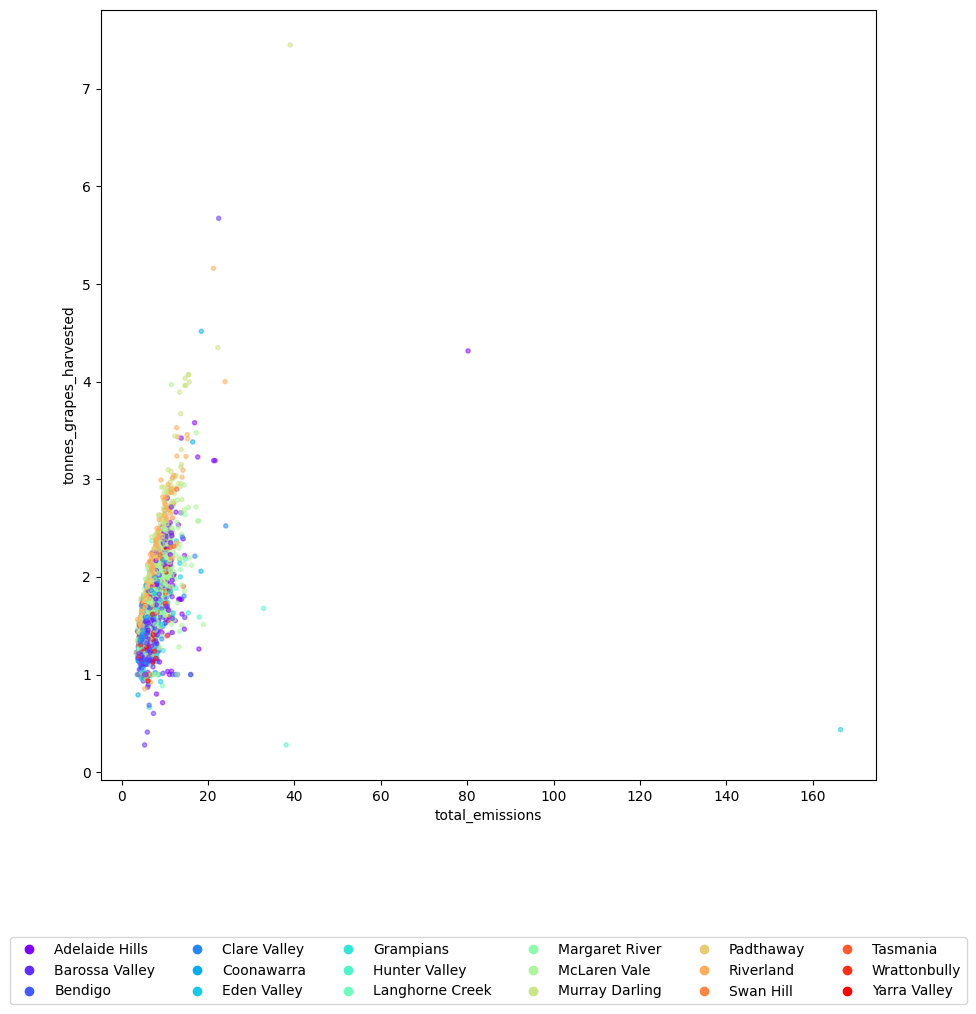

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df[df["giregion"].isin(region_selection)]["water_and_emmissions"],
    df[df["giregion"].isin(region_selection)]['yield'],
    c=df[df["giregion"].isin(region_selection)]["colors"]
    , label=df["giregion"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

    
plt.show()

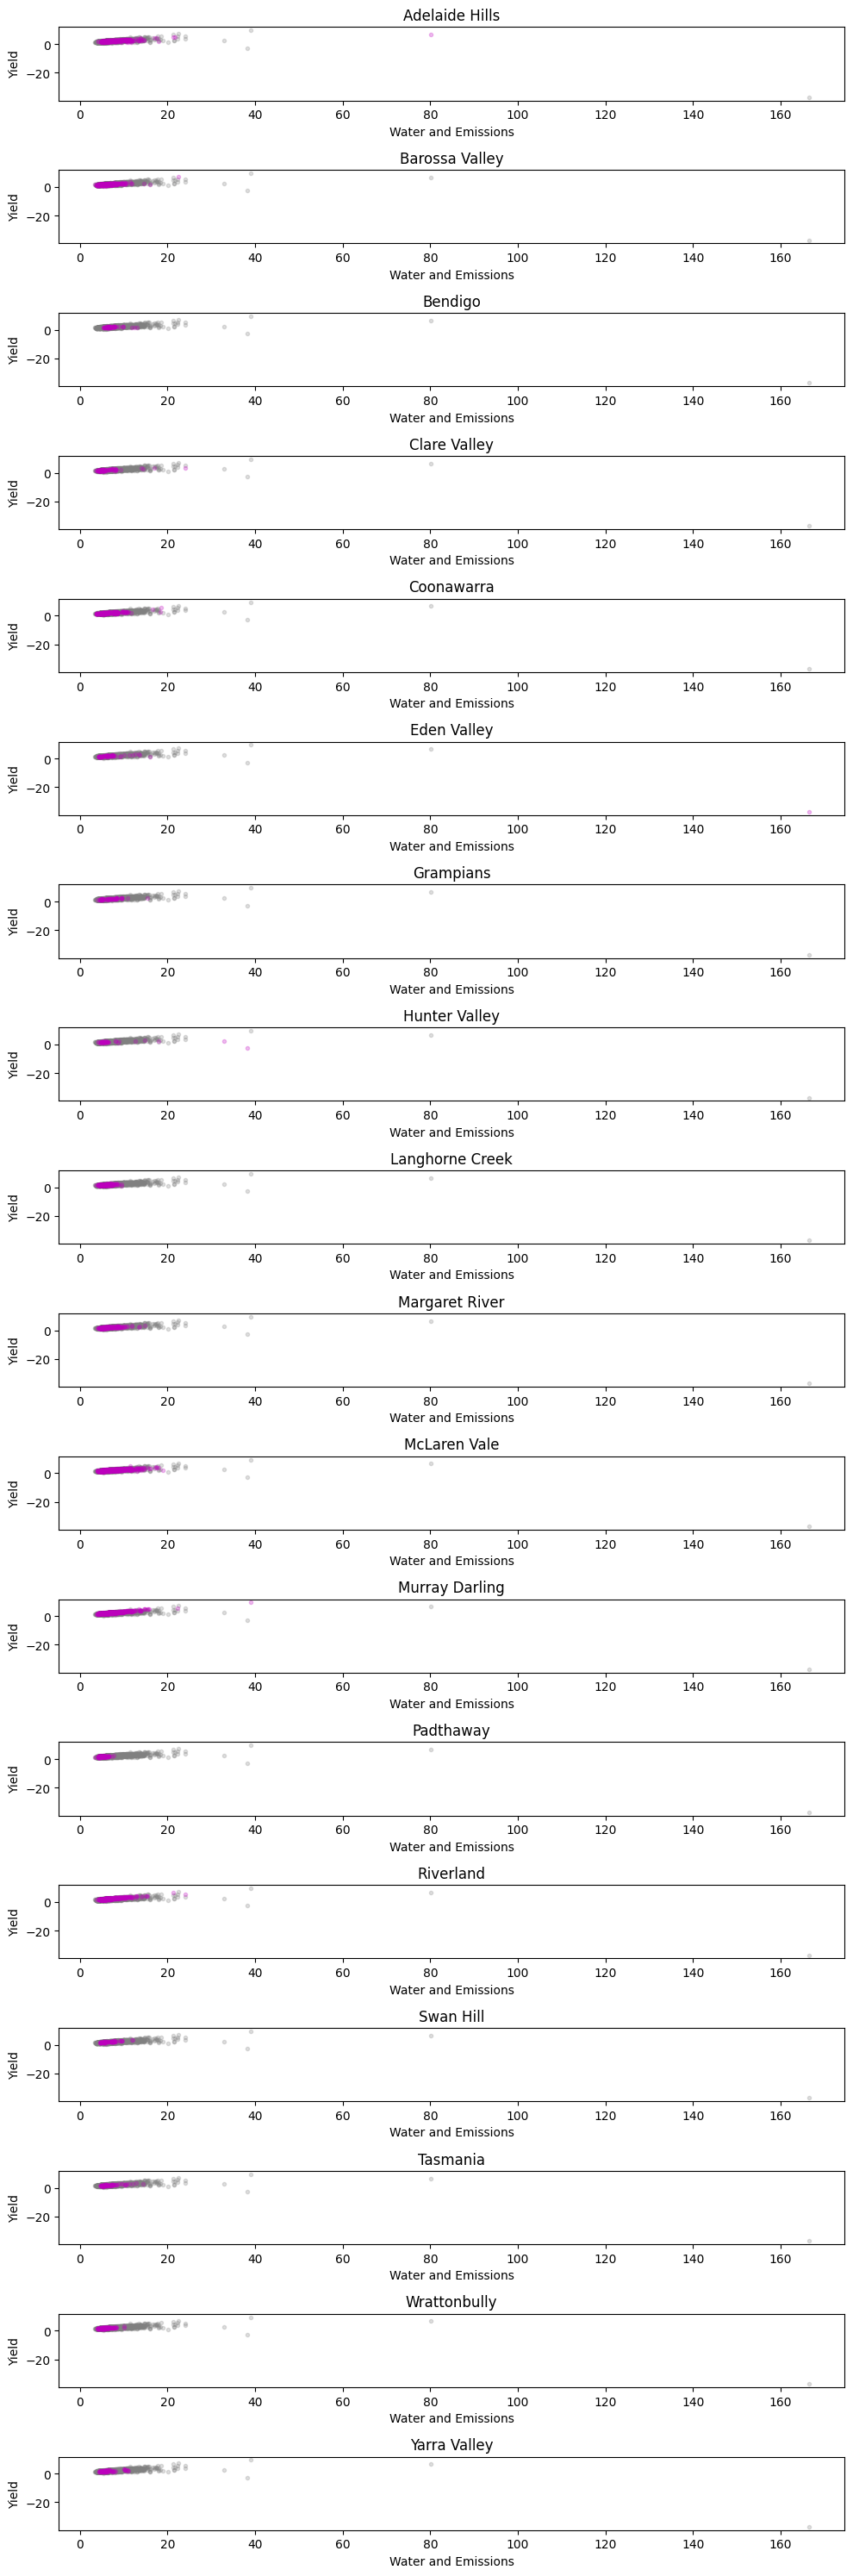

In [57]:
fig, ax = plt.subplots(len(region_selection), 1,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]!=region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]!=region, "area_harvested"]).apply(np.log))
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]==region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]==region, "area_harvested"]).apply(np.log))
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i].set_title(region)
    ax[i].set_xlabel("Water and Emissions")
    ax[i].set_ylabel('Yield')
    
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

### Finances

In [58]:
df.groupby("giregion")["average_per_tonne"].describe()

count         mean          std     min      25%  \
giregion                                                                     
0                           2.0  1325.000000   388.908730  1050.0  1187.50   
Adelaide Hills             60.0  1878.683333   380.167960  1025.0  1703.75   
Adelaide Plains             5.0  1227.000000   191.428838   935.0  1200.00   
Alpine Valleys              2.0  1125.000000   247.487373   950.0  1037.50   
Barossa Valley             95.0  2836.252632  1363.352103   757.0  2050.00   
Barossa Zone                3.0  2043.333333   487.476495  1530.0  1815.00   
Beechworth                  1.0  2600.000000          NaN  2600.0  2600.00   
Bendigo                    13.0  1503.230769   417.431462   750.0  1400.00   
Big Rivers Zone Other       0.0          NaN          NaN     NaN      NaN   
Blackwood Valley            2.0  1125.000000   318.198052   900.0  1012.50   
Canberra District           5.0  2176.000000   599.691587  1500.0  1800.00   
Clare Valley               22.0  1941.909091   701.918386  1129.0  1461.25   
Coonawarra                 38.0  2124.826316   818.951363  1100.0  1593.25   
Cowra                       0.0          NaN          NaN     NaN      NaN   
Currency Creek              4.0  1554.500000   472.737771  1018.0  1229.50   
Eden Valley                27.0  2084.074074   445.862425  1214.0  1779.50   
Geelong                     0.0          NaN          NaN     NaN      NaN   
Geographe                   0.0          NaN          NaN     NaN      NaN   
Glenrowan                   0.0          NaN          NaN     NaN      NaN   
Goulburn Valley             1.0  1113.000000          NaN  1113.0  1113.00   
Grampians                   5.0  1830.000000   449.444101  1300.0  1450.00   
Great Southern              3.0  2067.166667  1033.251704  1350.0  1475.00   
Gundagai                    1.0   850.000000          NaN   850.0   850.00   
Heathcote                   2.0  1100.000000    70.710678  1050.0  1075.00   
Henty                       0.0          NaN          NaN     NaN      NaN   
Hunter Valley               2.0  1862.500000   265.165043  1675.0  1768.75   
Kangaroo Island             1.0  1300.000000          NaN  1300.0  1300.00   
King Valley                 8.0  1018.755000   113.667347   880.0   937.50   
Langhorne Creek            45.0  1062.502667   370.529436   525.0   832.00   
Macedon Ranges              1.0  3494.000000          NaN  3494.0  3494.00   
Margaret River             46.0  1773.099565   556.838382  1100.0  1381.25   
McLaren Vale              215.0  2357.847814  1756.368294     1.0  1800.00   
Mornington Peninsula        3.0  2833.333333   404.145188  2600.0  2600.00   
Mount Benson                1.0  1600.000000          NaN  1600.0  1600.00   
Mount Gambier               1.0  1600.000000          NaN  1600.0  1600.00   
Mudgee                      6.0  1850.000000   126.491106  1700.0  1762.50   
Murray Darling             62.0   489.309032   174.324358   160.0   398.50   
Orange                     18.0  1637.666667   620.962062   260.0  1269.75   
Other                       3.0  1186.666667  1137.555859   510.0   530.00   
Padthaway                  20.0  1581.235000   712.711361   830.0  1093.75   
Pemberton                   5.0  1429.400000   250.523053  1200.0  1200.00   
Pyrenees                    0.0          NaN          NaN     NaN      NaN   
Riverina                    0.0          NaN          NaN     NaN      NaN   
Riverland                  83.0   530.487108   200.087335     1.0   430.00   
Robe                        1.0  1200.000000          NaN  1200.0  1200.00   
Rutherglen                  9.0  1315.333333   568.540236   700.0  1015.00   
Southern Fleurieu           4.0  1088.000000   130.802650   952.0   988.00   
Southern Flinders Ranges    1.0   838.000000          NaN   838.0   838.00   
Southern Highlands          0.0          NaN          NaN     NaN      NaN   
Strathbogie Ranges          2.0  1400.000000   1

In [59]:
df.columns

Index(['member_id', 'data_year_id', 'vineyard_area', 'area_harvested',
       'tonnes_grapes_harvested', 'water_used', 'total_tractor_passes',
       'total_vineyard_fuel', 'total_vineyard_electricity',
       'total_irrigation_area', 'synthetic_nitrogen_applied',
       'organic_nitrogen_applied', 'synthetic_fertiliser_applied',
       'organic_fertiliser_applied', 'area_not_harvested',
       'total_irrigation_electricity', 'total_irrigation_fuel', 'giregion',
       'fertilizer_s1', 'fertilizer_s2', 'fertilizer_s3', 'fertilizer_s4',
       'fertilizer_s5', 'fertilizer_o1', 'fertilizer_o2', 'fertilizer_o3',
       'fertilizer_o4', 'fertilizer_o5', 'vineyard_area_white_grapes',
       'vineyard_area_red_grapes', 'river_water', 'groundwater',
       'surface_water_dam', 'recycled_water_from_other_source', 'mains_water',
       'other_water', 'water_applied_for_frost_control', 'bare_soil',
       'annual_cover_crop', 'permanent_cover_crop_native',
       'permanent_cover_crop_non_native

In [60]:
rpy2.ipython.html.init_printing()
r = robjects.r
#feature_list.append("average_per_tonne")

from data import mean_sale_price

avg_prices = df[
    df["average_per_tonne"].isnull()].apply(
    lambda x: mean_sale_price(x["giregion"],
                              x["data_year_id"]),
    axis=1)
df["average_per_tonne"] = df["average_per_tonne"].replace({0: np.nan})
df["average_per_tonne"] = df["average_per_tonne"].combine_first(avg_prices)

dfr = df.loc[df[df["average_per_tonne"]!=0].index, feature_list].copy()
dfr["average_per_tonne"] = df.loc[df[df["average_per_tonne"]!=0].index, "average_per_tonne"]

dfr.to_csv("data.csv")

r.source("linear_model.r")

model = r.linear_model("data.csv", "(log(df$average_per_tonne*df$tonnes_grapes_harvested+1))/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * df$tonnes_grapes_harvested + 1))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    2913
log(df$total_emissions + 1)                             1   3496.7      2912
log(df$water_used + 1)                                  1    225.8      2911
log(df$total_emissions + 1):log(df$area_harvested + 1)  1    558.3      2910
log(df$area_harvested + 1):log(df$water_used + 1)       1    914.7      2909
                                                       Resid. Dev
NULL                                                       9795.3
log(df$total_emissions + 1)                                6298.6
log(df$water_used + 1)                                     6072.7
log(df$total_emissions + 1):log(df$ar

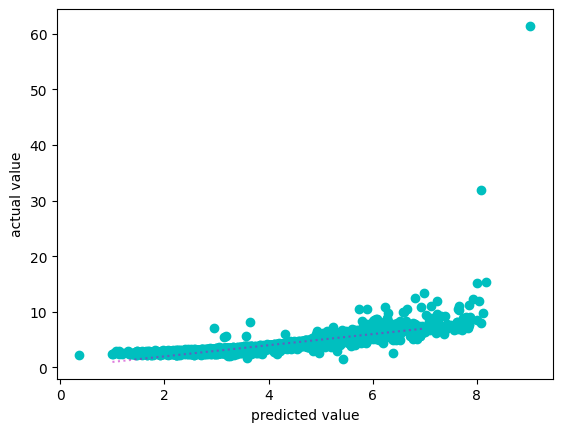

In [61]:
fig, ax = plt.subplots()

plt.plot([1,7], [1,7], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c")

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

(array([1.000e+00, 1.000e+00, 1.500e+01, 8.300e+01, 3.170e+02, 2.902e+03,
        1.836e+03, 1.780e+02, 4.200e+01, 1.000e+01, 4.000e+00, 1.100e+01,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-2.09382876, -1.73664328, -1.3794578 , -1.02227232, -0.66508683,
        -0.30790135,  0.04928413,  0.40646961,  0.76365509,  1.12084057,
         1.47802605,  1.83521153,  2.19239701,  2.54958249,  2.90676797,
         3.26395345,  3.62113893,  3.97832441,  4.33550989,  4.69269537,
         5.04988085]),
 <BarContainer object of 20 artists>)

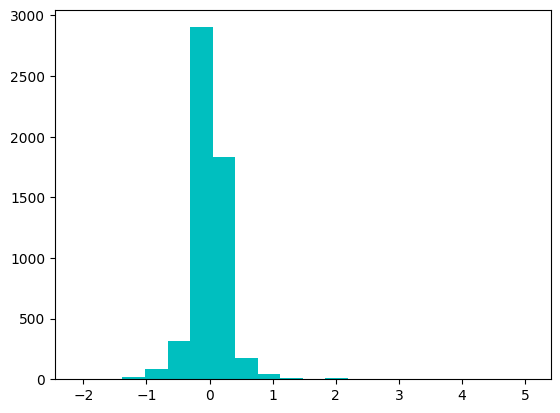

In [62]:
plt.hist(residuals, bins=20, color="c")

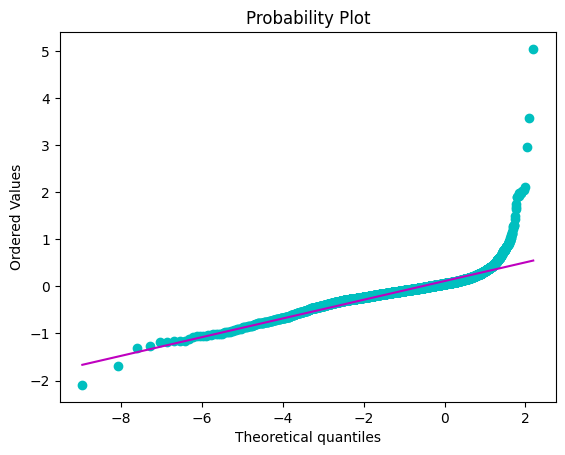

In [63]:
from scipy import stats


from scipy import stats



fig, ax = plt.subplots()

stats.probplot(
    residuals
    , dist=stats.loggamma
    , sparams=(1)
    , plot=ax
)

ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

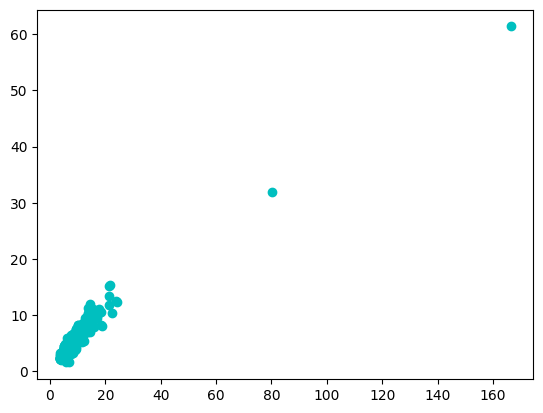

In [64]:
df["yield_avg"] = (1+(df['average_per_tonne']*df['tonnes_grapes_harvested'])).apply(np.log).div((1+df["area_harvested"]).apply(np.log))

plt.scatter(df["water_and_emmissions"], df["yield_avg"], color="c")

plt.show()

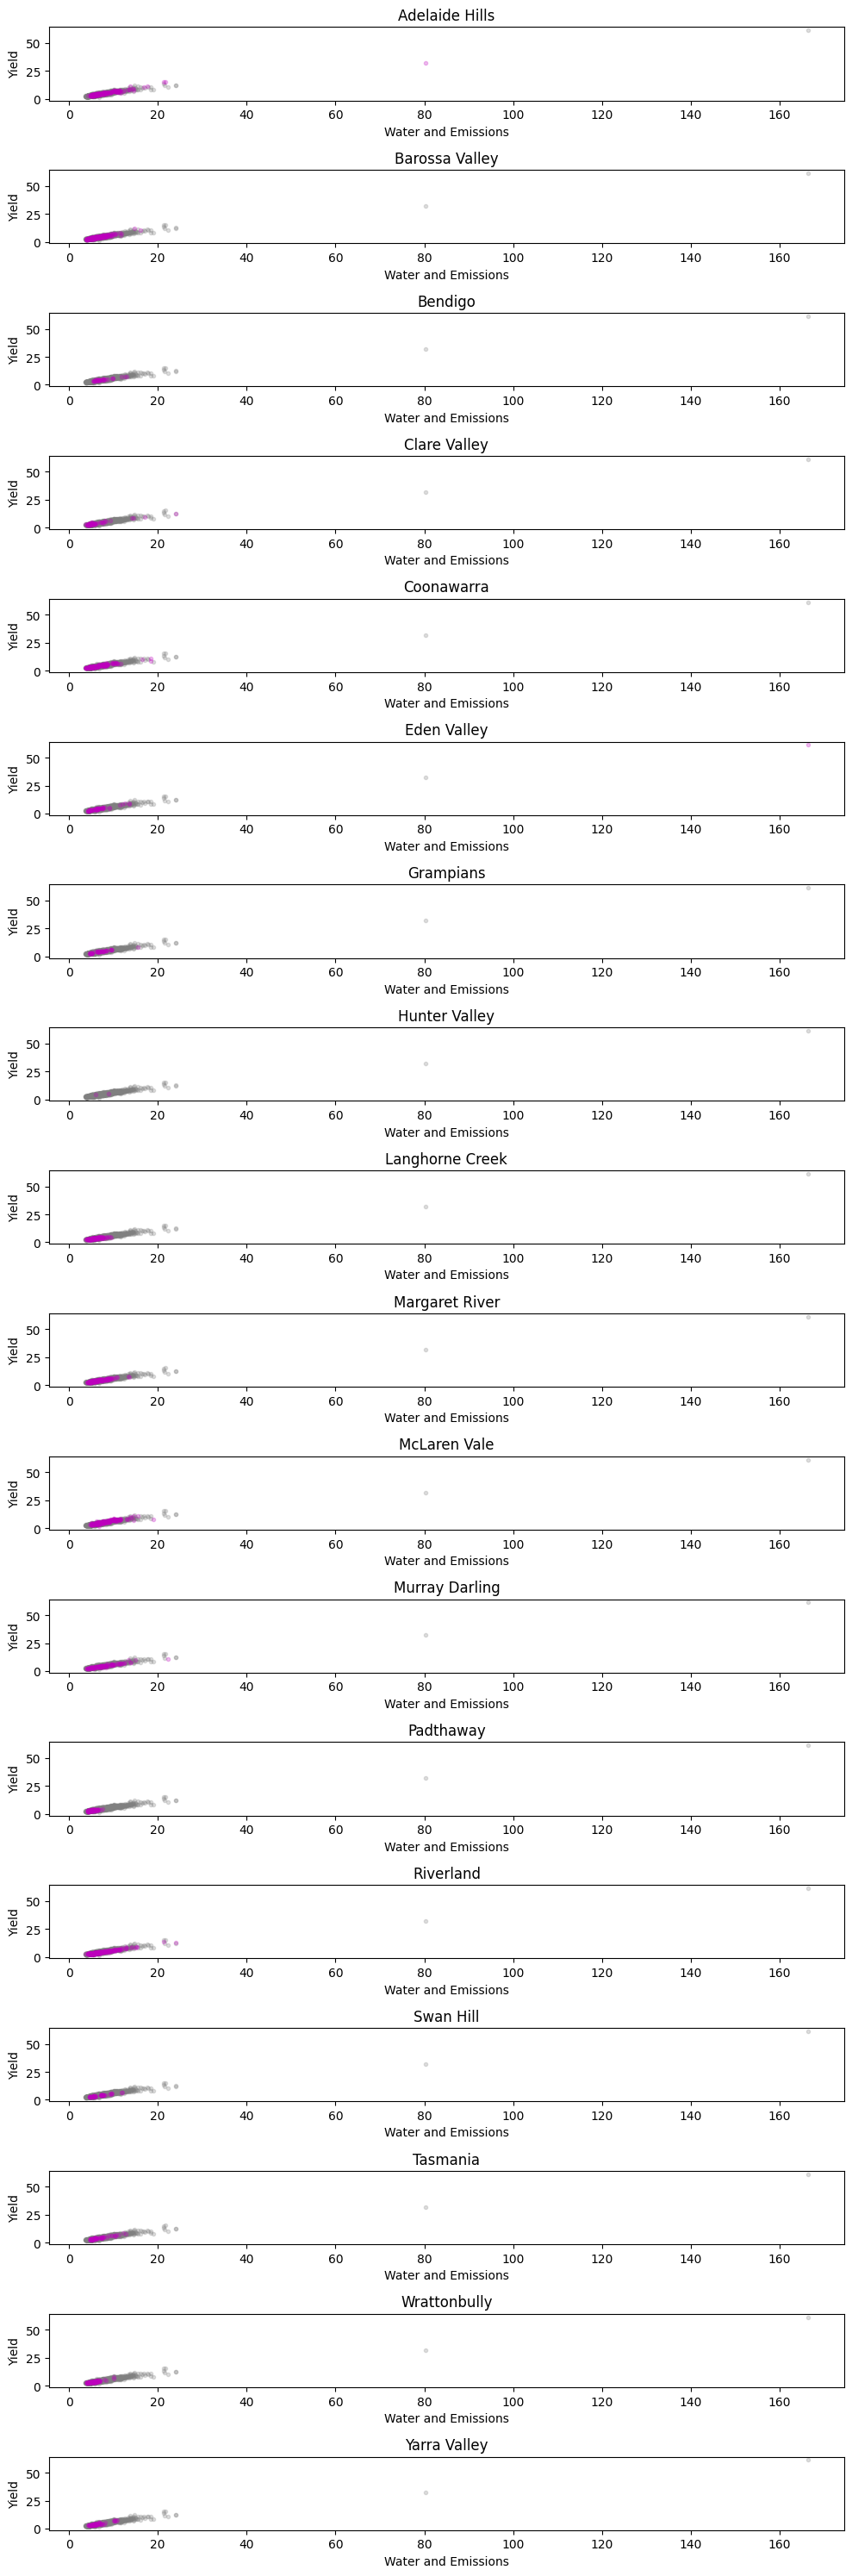

In [65]:
fig, ax = plt.subplots(len(region_selection), 1,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , df.loc[df["giregion"]!=region, 'yield_avg']
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , df.loc[df["giregion"]==region, 'yield_avg']
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i].set_title(region)
    ax[i].set_xlabel("Water and Emissions")
    ax[i].set_ylabel('Yield')
    
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

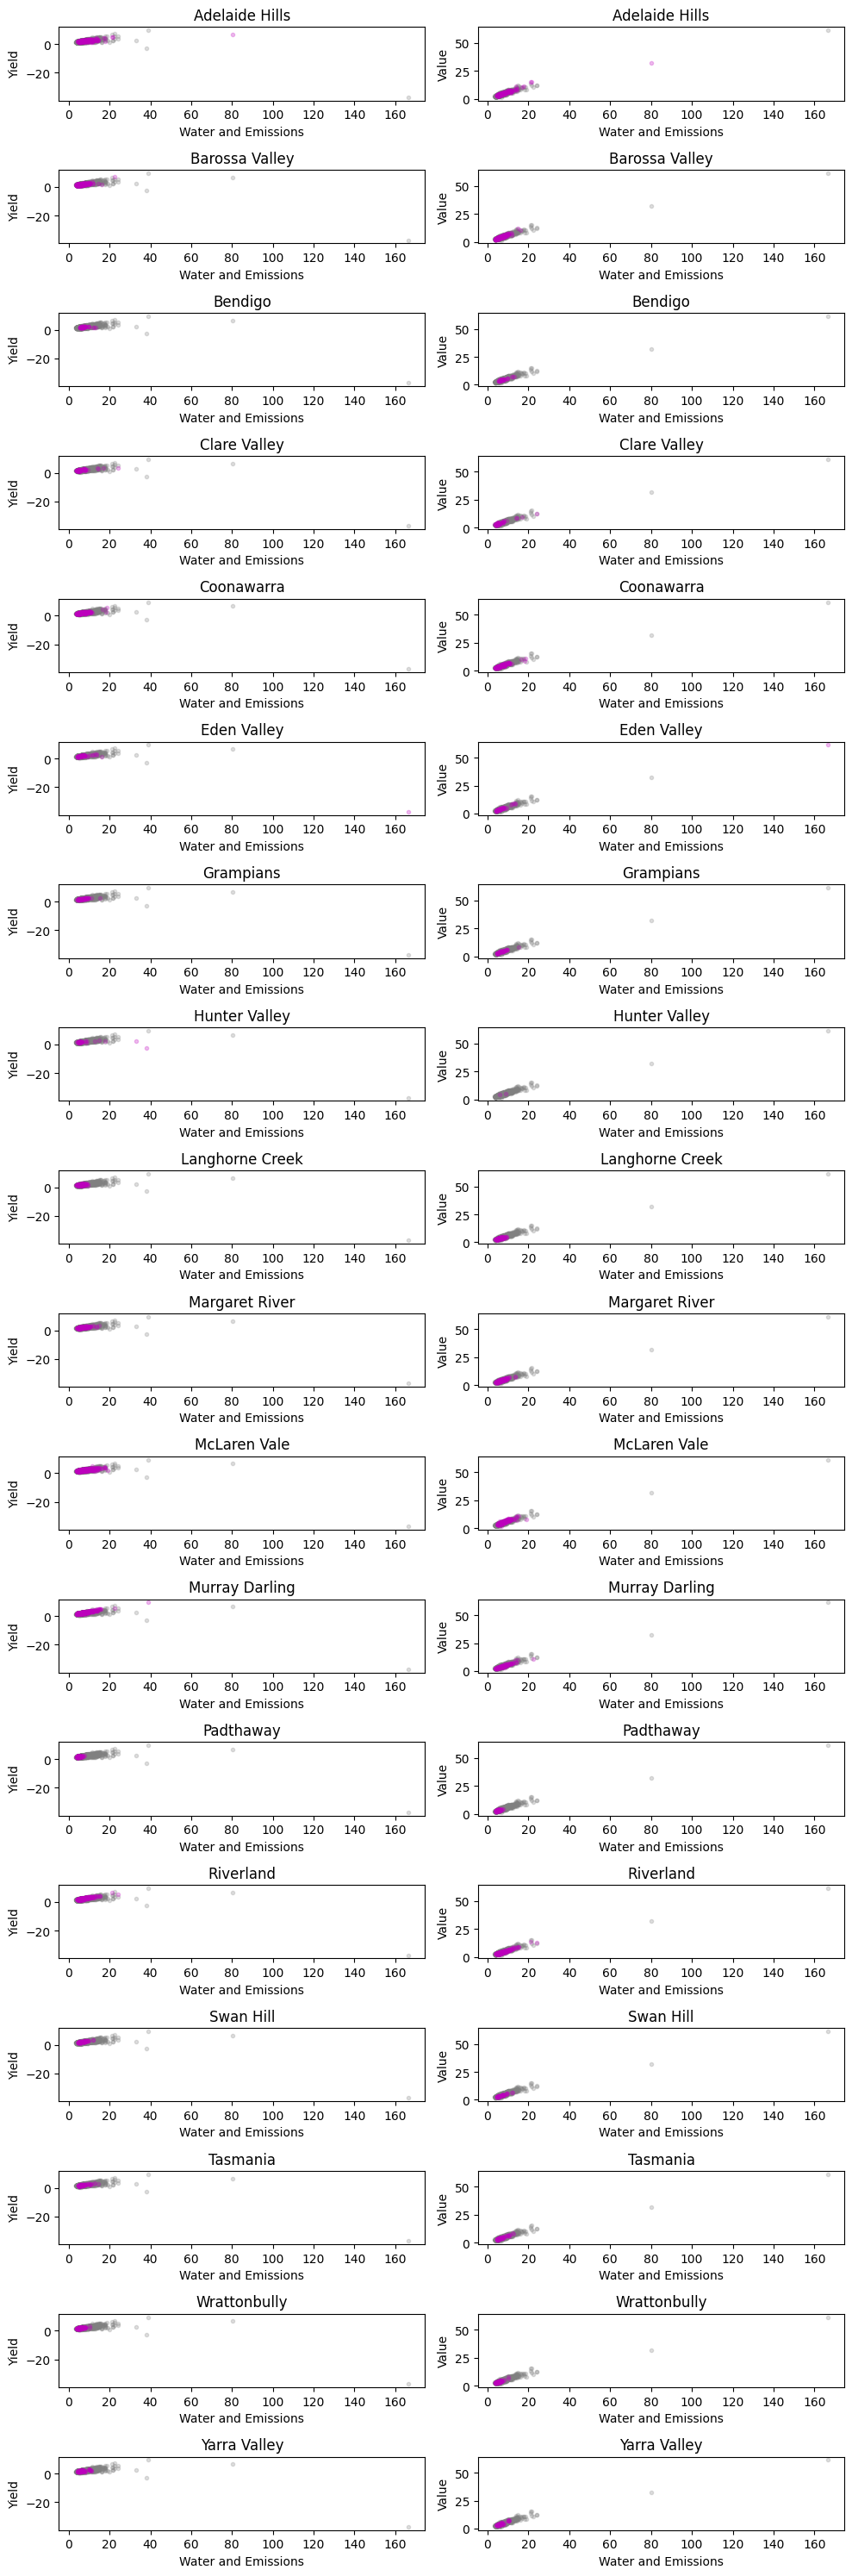

In [66]:
fig, ax = plt.subplots(len(region_selection), 2,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i][0].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]!=region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]!=region, "area_harvested"]).apply(np.log))
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i][0].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]==region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]==region, "area_harvested"]).apply(np.log))
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i][0].set_title(region)
    ax[i][0].set_xlabel("Water and Emissions")
    ax[i][0].set_ylabel('Yield')
    ##
    axscatter = ax[i][1].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , df.loc[df["giregion"]!=region, 'yield_avg']
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i][1].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , df.loc[df["giregion"]==region, 'yield_avg']
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i][1].set_title(region)
    ax[i][1].set_xlabel("Water and Emissions")
    ax[i][1].set_ylabel('Value')
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

# CARTS

In [67]:
feature_list

['area_harvested',
 'tonnes_grapes_harvested',
 'water_used',
 'total_tractor_passes',
 'synthetic_nitrogen_applied',
 'organic_nitrogen_applied',
 'synthetic_fertiliser_applied',
 'organic_fertiliser_applied',
 'slashing_number_of_times_passes_per_year',
 'fungicide_spraying_number_of_times_passes_per_year',
 'herbicide_spraying_number_of_times_passes_per_year',
 'insecticide_spraying_number_of_times_passes_per_year',
 'nitrogen_applied',
 'fertiliser_applied',
 'total_emissions']

### Regional Climates

In [72]:
df["rain"] = df["giregion"].apply(rain)
df["temp"] = df["giregion"].apply(temp)
df.loc[df["rain"]=="Unknown Climate", "rain"] = np.nan
df.loc[df["temp"]=="Unknown Climate", "temp"] = np.nan
df["climate"] = df["temp"] + " " + df["rain"]
df.loc[df["climate"]=="Unknown Climate Unknown Climate", "climate"] = np.nan

In [73]:
df["climate"].unique()

array(['Warm Very Dry', 'Mild Dry', 'Hot Damp', 'Cool Dry', 'Warm Dry',
       'Hot Very Dry', 'Cool Damp', 'Mild Very Dry', 'Warm Damp', nan,
       'Mild Damp', 'Cool Very Dry'], dtype=object)

<AxesSubplot: >

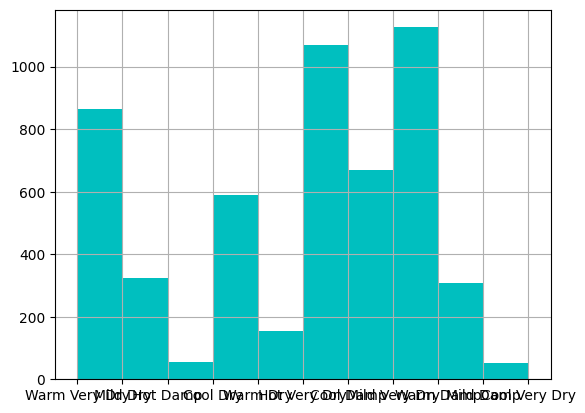

In [74]:
df["climate"].hist(color="c")

<AxesSubplot: >

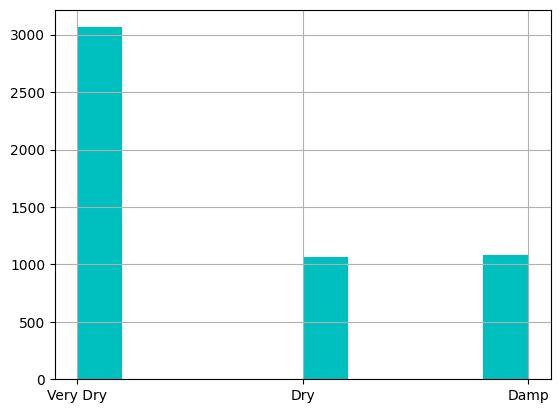

In [75]:
df["rain"].hist(color="c")

<AxesSubplot: >

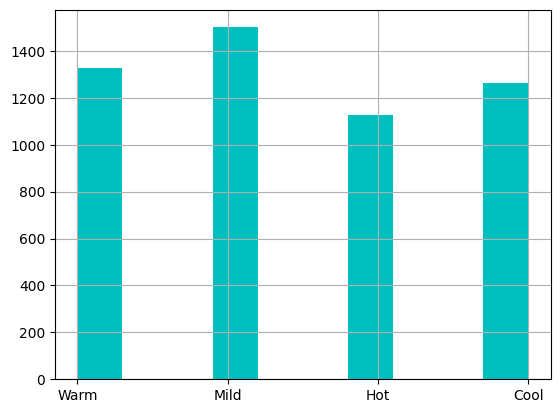

In [76]:
df["temp"].hist(color="c")

In [77]:
df["yield/ha"] = df["tonnes_grapes_harvested"].div(df["area_harvested"])
df["yield*avg/ha"] = df["tonnes_grapes_harvested"]*df["average_per_tonne"]
df["yield*avg/ha"] = df["yield*avg/ha"].div(df["area_harvested"])

class_features = feature_list
class_features.append("giregion")
class_features.append("yield/ha")
class_features.append("yield*avg/ha")
class_features.append("rain")
class_features.append("temp")
class_features.append("climate")

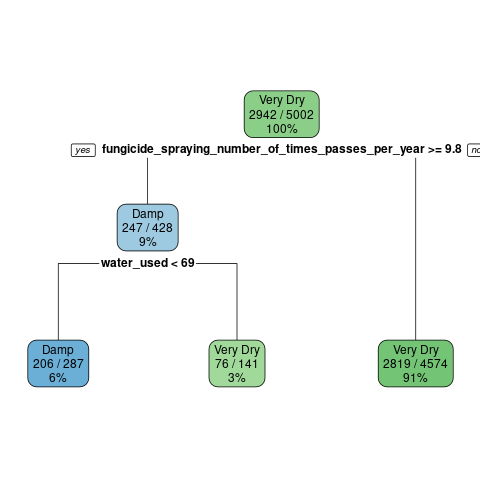

In [179]:
from IPython import display
display.Image(filename=".tree.png")

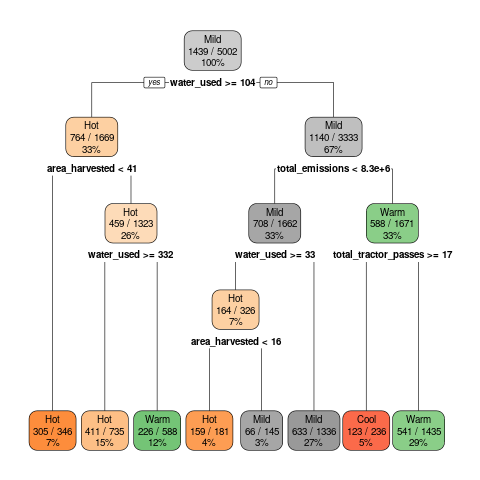

In [181]:
from IPython import display
display.Image(filename=".tree.png")

In [81]:
palette=[
        "#009292",
        "#ff6db6",
        "#490092",
        "#b66dff",
        "#6db6ff",
        "#b6dbff",
        "#920000",
        "#db6d00",
        "#24ff24",
        "#ffff6d",
        "#006ddb",
        "#000000",
        "#004949",
        "#ffb6db",
        "#924900",
    ]

import matplotlib.cm as cm

climate_color = {}
color = iter(palette)

climate_selection = df["climate"].unique()

for i in range(len(climate_selection)):
   climate_color[climate_selection[i]] = i = next(color)

df['clim_colors'] = df.loc[df["climate"].notnull(), "climate"].apply(lambda x: climate_color[x])

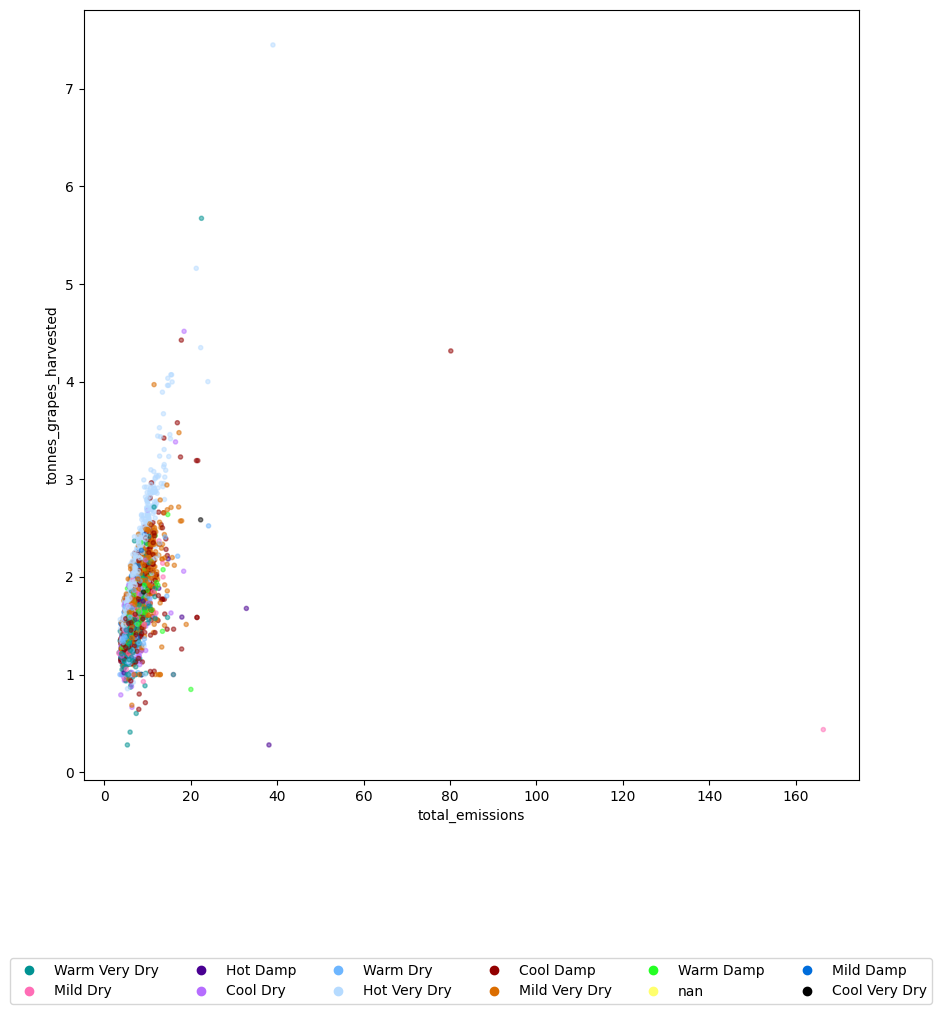

In [82]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(),"water_and_emmissions"],
    df.loc[df["climate"].notnull(),'yield'],
    c=df.loc[df["climate"].notnull(),"clim_colors"]
    , label=df.loc[df["climate"].notnull(),"climate"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in climate_color.values()]
plt.legend(markers, climate_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

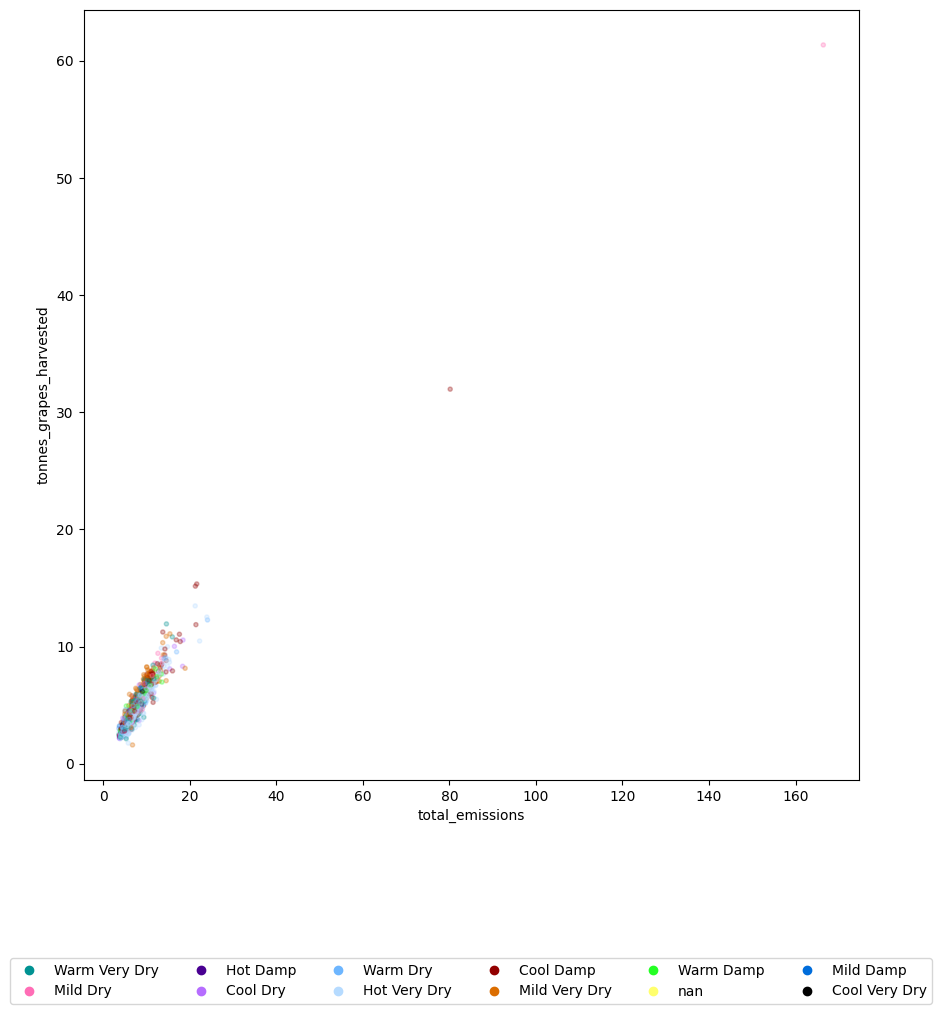

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(),"water_and_emmissions"],
    df.loc[df["climate"].notnull(),'yield_avg'],
    c=df.loc[df["climate"].notnull(),"clim_colors"]
    , label=df.loc[df["climate"].notnull(),"climate"]
    , marker= "."
    , alpha=0.3
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in climate_color.values()]
plt.legend(markers, climate_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

    
plt.show()

In [84]:
import matplotlib.cm as cm

rain_color = {}
color = iter(palette)

rain_selection = df.loc[df["climate"].notnull(), "rain"].unique()

for i in range(len(rain_selection)):
   rain_color[rain_selection[i]] = i = next(color)

df['rain_colors'] = df.loc[df["climate"].notnull(),"rain"].apply(lambda x: rain_color[x])

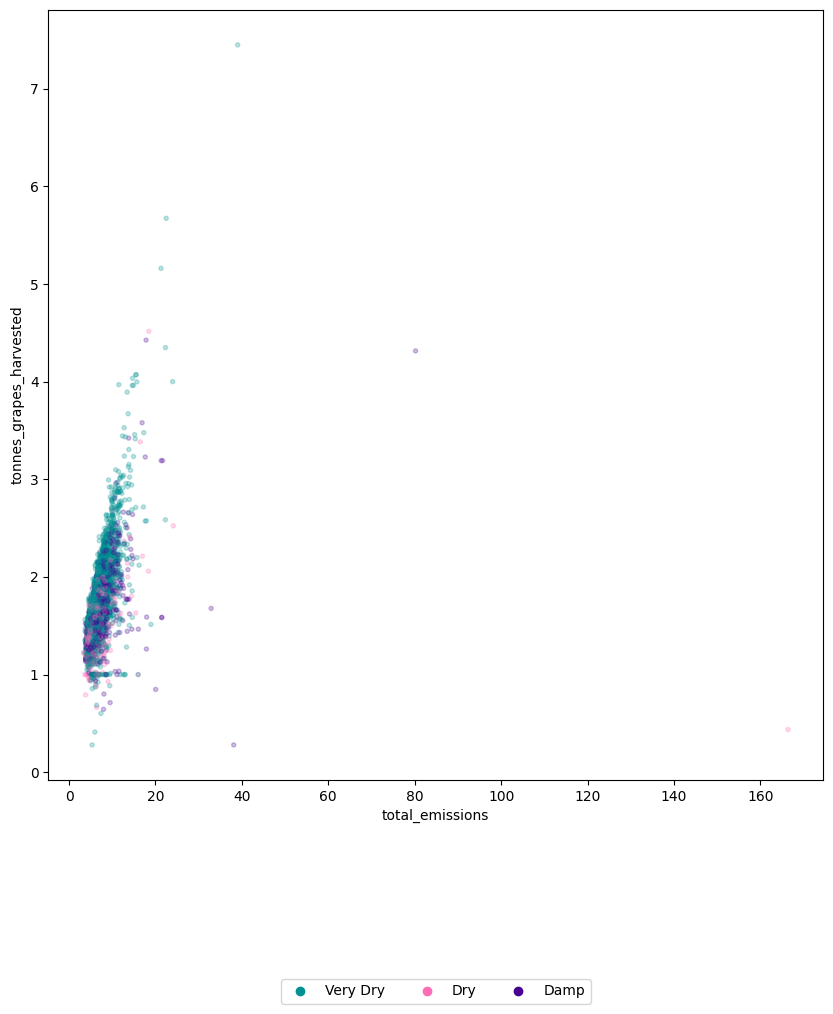

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

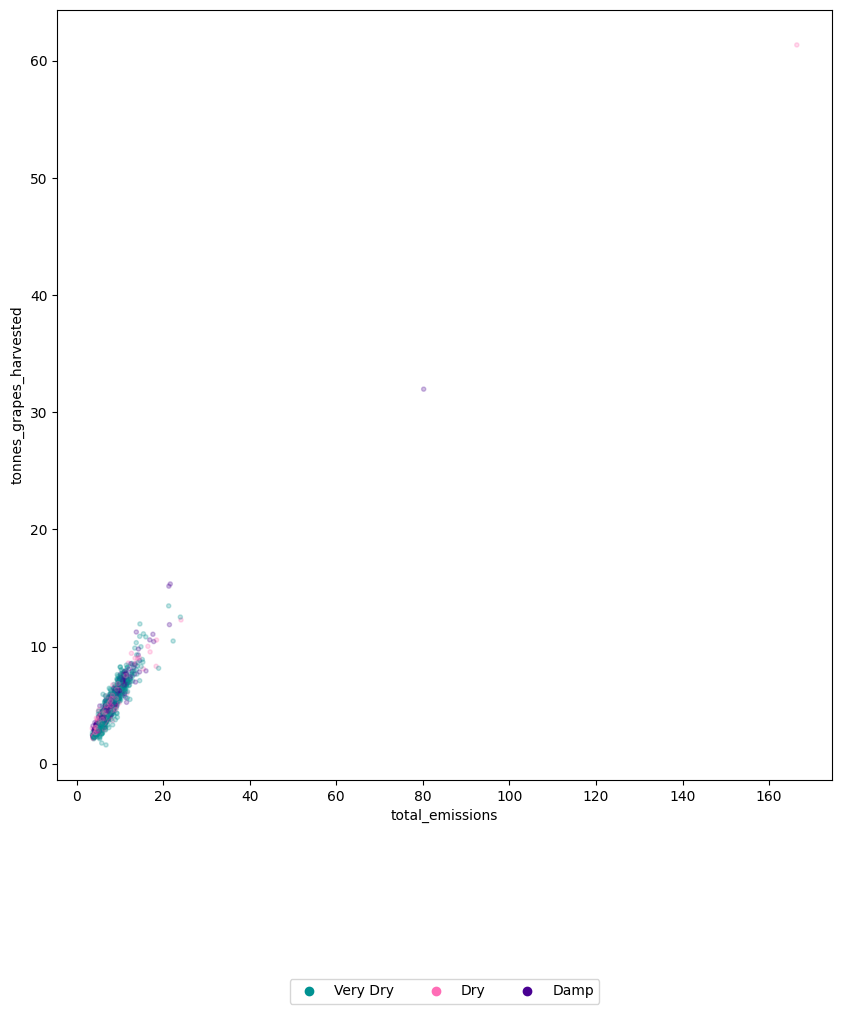

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested * average grape price')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

KeyError: 'climate'

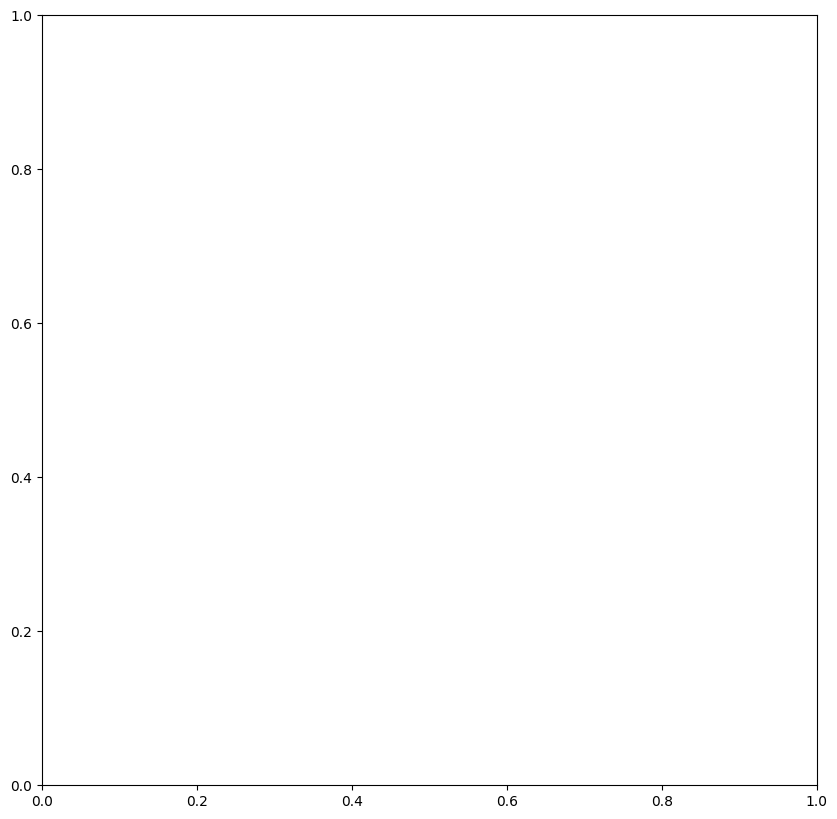

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))
rain_map = {'Very Dry': "brown", 'Damp': "blue", 'Dry': "brown", 'Unknown Climate': None}

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested * average grape price')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')
ax.set_xlim([3.5,12])
ax.set_ylim([2,6])

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

In [189]:
temp_selection = df.groupby("temp").count()[(df.groupby("temp").count()>50)["member_id"]].index.values

import matplotlib.cm as cm

temp_color = {}
color = iter(palette)
temp_selection = df.loc[df["climate"].notnull(), "temp"].unique()

for i in range(len(temp_selection)):
   temp_color[temp_selection[i]] = i = next(color)

df['temp_colors'] = df.loc[df["climate"].notnull(), "temp"].apply(lambda x: temp_color[x])

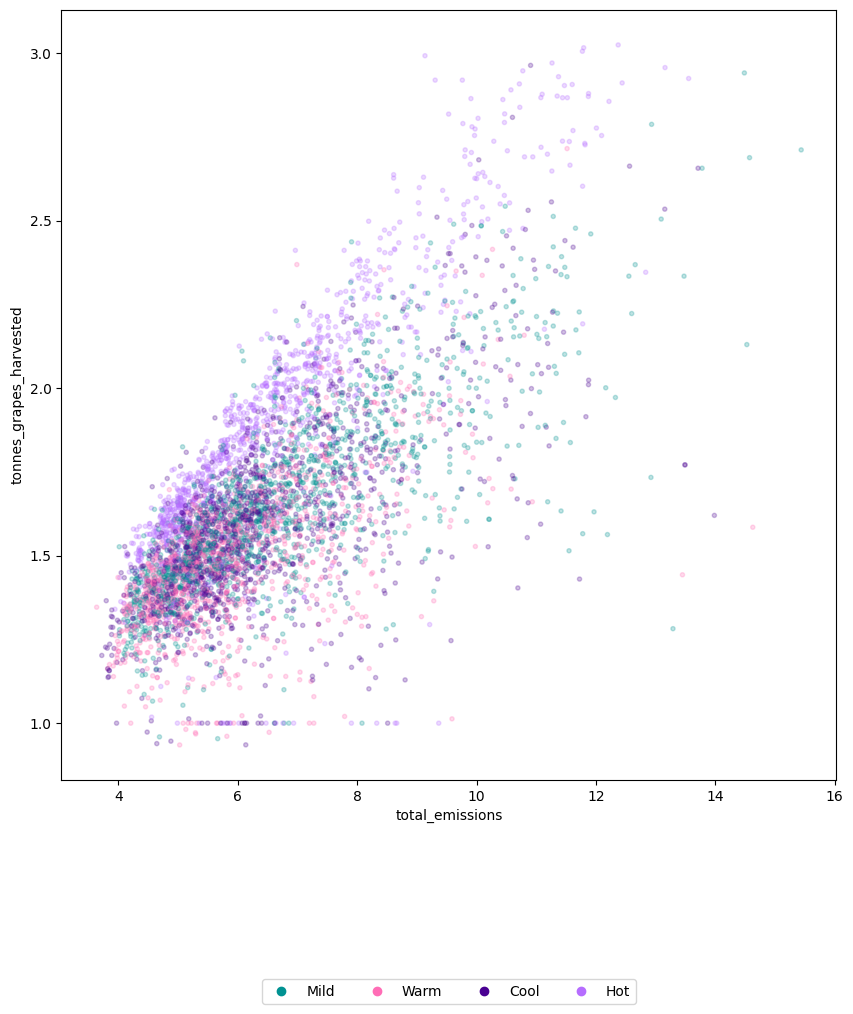

In [190]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

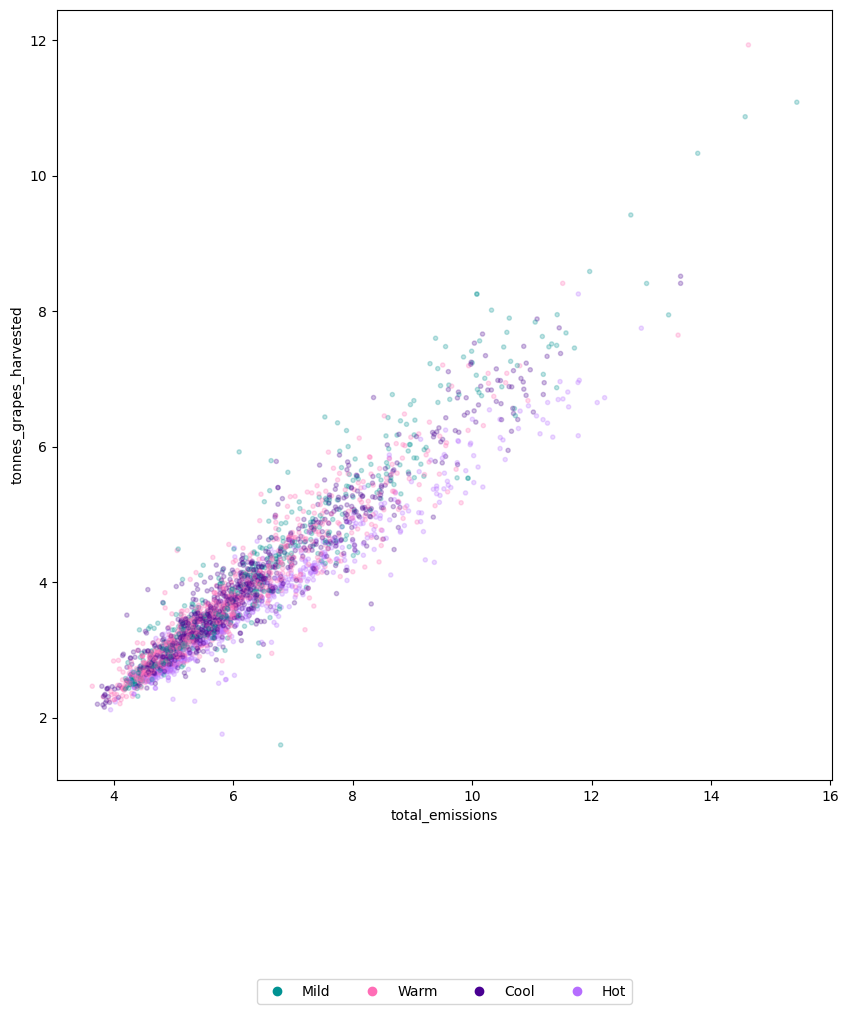

In [191]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

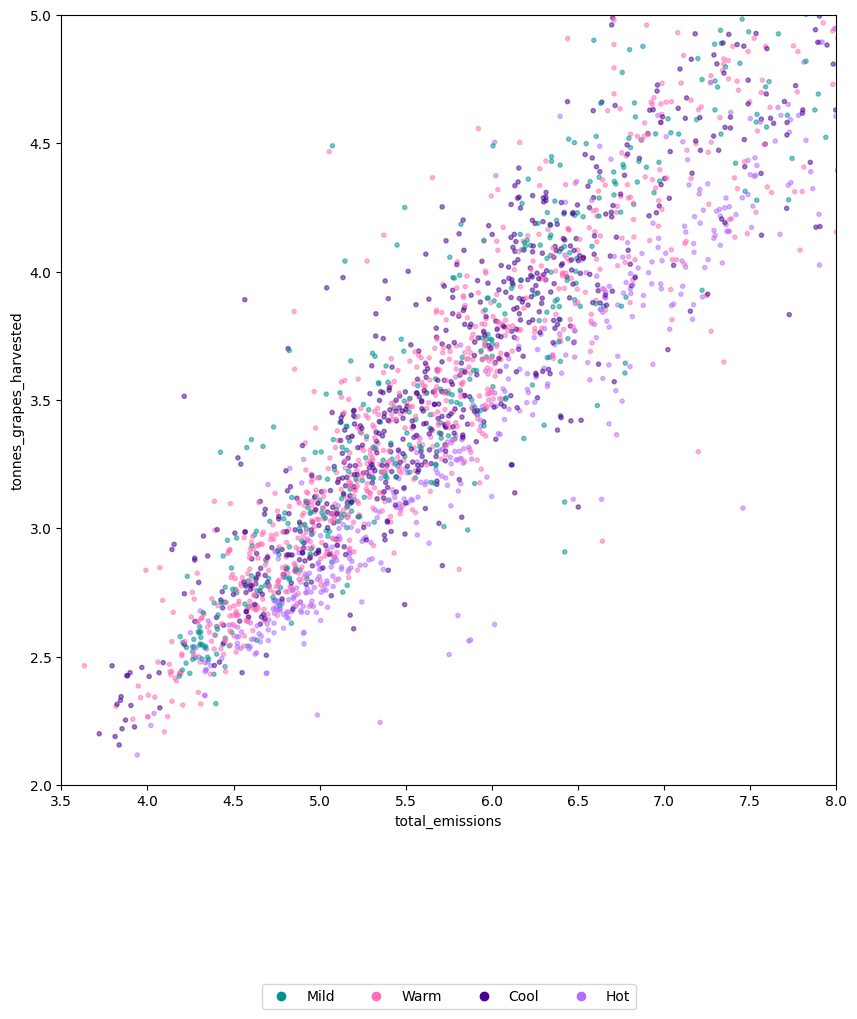

In [192]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

ax.set_xlim([3.5,8])
ax.set_ylim([2,5])

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

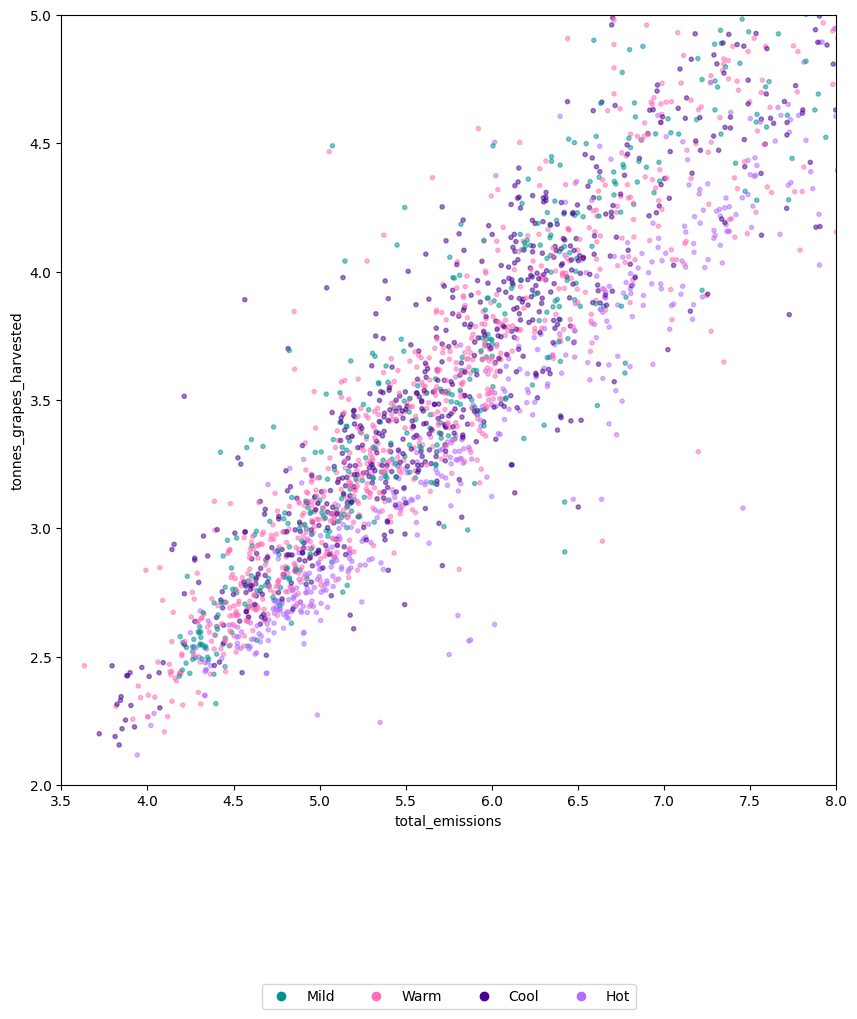

In [193]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

ax.set_xlim([3.5,8])
ax.set_ylim([2,5])

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

In [212]:
df["use_contractors"] = df['slashing_number_of_times_passes_per_year'].replace({np.nan: 0}) +\
       df['fungicide_spraying_number_of_times_passes_per_year'].replace({np.nan: 0}) +\
       df['herbicide_spraying_number_of_times_passes_per_year'].replace({np.nan: 0}) +\
       df['insecticide_spraying_number_of_times_passes_per_year'].replace({np.nan: 0})
df.loc[df["use_contractors"] > 0, "use_contractors"] = 1
df["use_contractors"] = df["use_contractors"].map({0: "No Contractors", 1: "Used Contractors"})
df["use_contractors"]

3351      No Contractors
5043    Used Contractors
3116      No Contractors
2033      No Contractors
671       No Contractors
              ...       
1949      No Contractors
3383      No Contractors
3491      No Contractors
3384    Used Contractors
5022      No Contractors
Name: use_contractors, Length: 5189, dtype: object

In [211]:
df["use_contractors"]

3351    NaN
5043    NaN
3116    NaN
2033    NaN
671     NaN
       ... 
1949    NaN
3383    NaN
3491    NaN
3384    NaN
5022    NaN
Name: use_contractors, Length: 5189, dtype: object

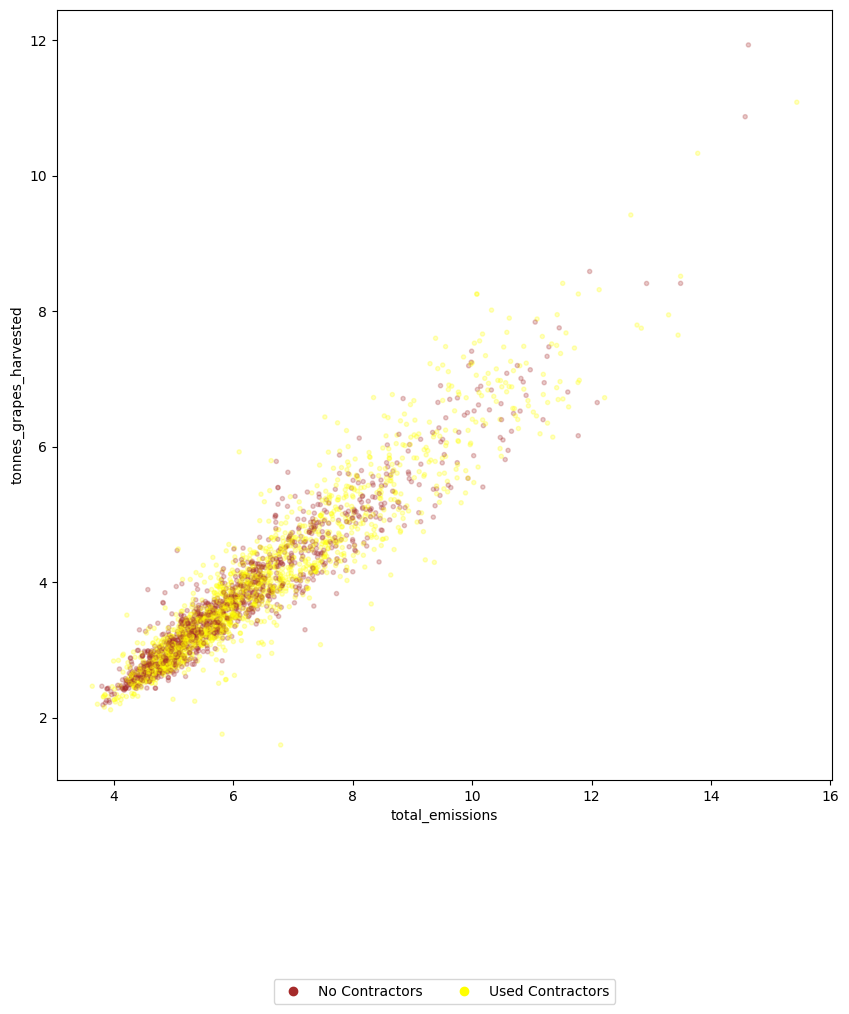

In [216]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = {"No Contractors": "brown", "Used Contractors": "yellow"}

scatter = ax.scatter(
    df["water_and_emmissions"],
    df['yield_avg']
    , c=df["use_contractors"].map(colors)
    , label=df["use_contractors"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in df["use_contractors"].map(colors).values]
plt.legend(markers, df["use_contractors"].unique(), loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

<AxesSubplot: >

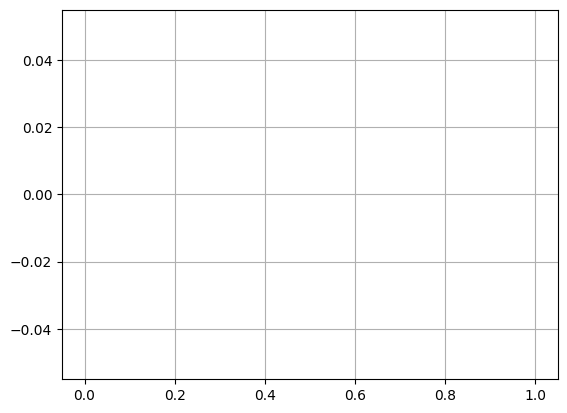

In [218]:
df[df["use_contractors"]=="No Contractors"]["water_and_emmissions"].hist()

<AxesSubplot: >

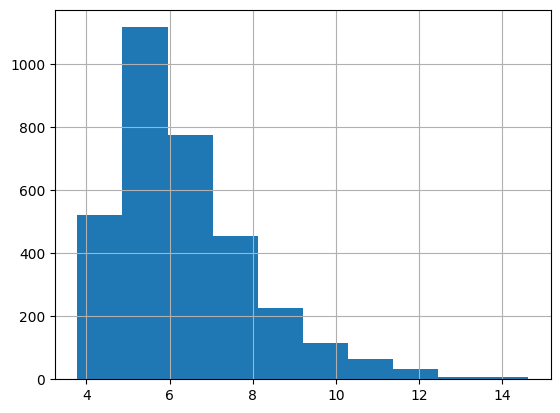

In [197]:
df[df["use_contractors"]==0]["water_and_emmissions"].hist()

In [219]:
df.columns

Index(['member_id', 'data_year_id', 'vineyard_area', 'area_harvested',
       'tonnes_grapes_harvested', 'water_used', 'total_tractor_passes',
       'total_vineyard_fuel', 'total_vineyard_electricity',
       'total_irrigation_area', 'synthetic_nitrogen_applied',
       'organic_nitrogen_applied', 'synthetic_fertiliser_applied',
       'organic_fertiliser_applied', 'area_not_harvested',
       'total_irrigation_electricity', 'total_irrigation_fuel', 'giregion',
       'fertilizer_s1', 'fertilizer_s2', 'fertilizer_s3', 'fertilizer_s4',
       'fertilizer_s5', 'fertilizer_o1', 'fertilizer_o2', 'fertilizer_o3',
       'fertilizer_o4', 'fertilizer_o5', 'vineyard_area_white_grapes',
       'vineyard_area_red_grapes', 'river_water', 'groundwater',
       'surface_water_dam', 'recycled_water_from_other_source', 'mains_water',
       'other_water', 'water_applied_for_frost_control', 'bare_soil',
       'annual_cover_crop', 'permanent_cover_crop_native',
       'permanent_cover_crop_non_native

In [220]:
df["use_renewables"] = df['irrigation_energy_solar'].replace({np.nan: 0}) +\
       df['vineyard_solar'].replace({np.nan: 0}) +\
       df['vineyard_wind'].replace({np.nan: 0}) +\
       df['biodiesel_vineyard'].replace({np.nan: 0})
df.loc[df["use_renewables"] > 0, "use_renewables"] = 1
df["use_renewables"] = df["use_renewables"].map({0: "No Renewables", 1: "Used Renewables"})
df["use_renewables"]

3351      No Renewables
5043    Used Renewables
3116    Used Renewables
2033      No Renewables
671       No Renewables
             ...       
1949      No Renewables
3383      No Renewables
3491      No Renewables
3384      No Renewables
5022      No Renewables
Name: use_renewables, Length: 5189, dtype: object

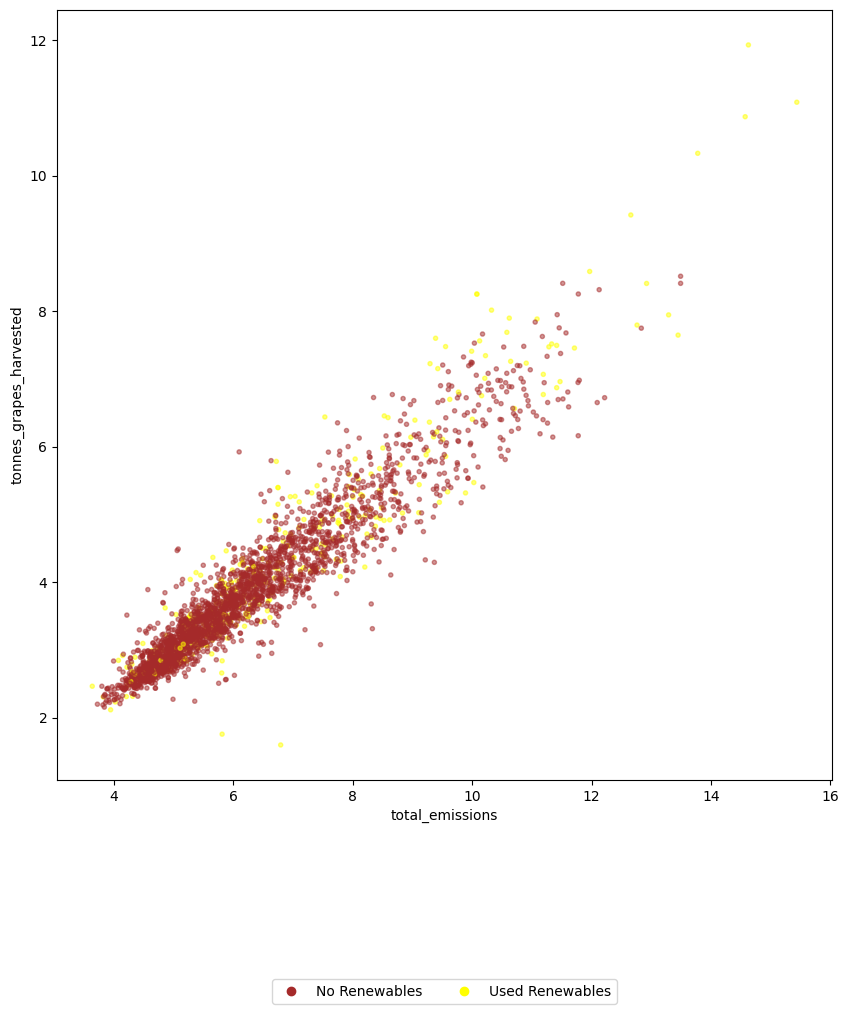

In [231]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = {"No Renewables": "brown", "Used Renewables": "yellow"}

scatter = ax.scatter(
    df["water_and_emmissions"],
    df['yield_avg']
    , c=df["use_renewables"].map(colors)
    , label=df["use_renewables"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in df["use_renewables"].map(colors).values]
plt.legend(markers, df["use_renewables"].unique(), loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()